# Сборный проект: аналитика данных о продажах игр

## Цели и задачи проекта

### Цель

Выявить определяющие успешность игры закономерности:
* под *успешностью* подразумевать увеличение показателей годовых продаж,
* под *закономерностями* понимать статистические зависимости параметров успешности игры от других параметров (дополнительной информации) об игре, наличествующих в исходных данных или выводимых на их основе.

### Задачи

1. Изучить и проанализировать исходный набор данных,
2. Найти статистические взаимосвязи в данных, согласно обязательного списка из Инструкций к проекту
3. Определить возможную модель для предсказания продаж на будущий год по истории продаж до конца прошлого года - в условиях достаточности данных и результатов их исследования,
4. Уточнить состав задач для построения модели предсказания продаж следующего года,
5. Решить поставленные задачи и построить модель предсказания продаж на будущий год,
6. Обосновать основные направления для целевого маркетинга по повышению продаж на следующий год.

#### Здесь уточненные после EDA задачи для построения модели предсказания годовых продаж

7. Предложить модель продаж игры - для пересчета распределений продаж по году выпуска игры к распределению продаж по году продажи,
8. Построить модель цикла жизни одного поколения игровых платформ и экстраполировать ее к поколению актуальному для года прогноза.

# Подготовка данных к анализу

## Описание исходных данных

Данные предоставлены в виде csv-файла "games.csv".  Данные представляют собой все продажи одной торговой сети с конца 80-х (судя по платформам) до условно "прошедшего года" (в условии значится до 2016, но сказано, что сам год не принципиален для методологии предсказания). Значения полей следующие:

* `Name            —` название игры
* `Platform        —` платформа
* `Year_of_Release —` год выпуска
* `Genre           —` жанр игры
* `NA_sales        —` продажи в Северной Америке (миллионы проданных копий)
* `EU_sales        —` продажи в Европе (миллионы проданных копий)
* `JP_sales        —` продажи в Японии (миллионы проданных копий)
* `Other_sales     —` продажи в других странах (миллионы проданных копий)
* `Critic_Score    —` оценка критиков (максимум 100)
* `User_Score      —` оценка пользователей (максимум 10)
* `Rating          —` рейтинг от организации ESRB

**Замечание:** странно, что нет поля с именем производителя игры - как правило, хорошее имя придает популярности!

## Предварительное знакомство с данными

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
# собираем весь import в одном месте по мере написания данной тетради

In [2]:
try: # сделаем код работающим без внесения коррекций на разных платформах - локально и на тренажере
    data_df = pd.read_csv('/datasets/games.csv')
except:
    data_df = pd.read_csv('datasets/games.csv')
    

In [3]:
data_df.head() # проверим визуально, успешно ли считались данные

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Случайно заметим:** у старых игр - в выводе 2 из 5 записей выше - нет рейтингов.  Их, видимо, тогда и не было объективно! 

In [4]:
data_df.info() # посмотрим на типы и кол-во данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Сразу видим по паре отсутствующих значений у `Name` и `Genre`.  Можно удалить все четыре, но имя игры маловероятно влияет на продажи, во всяком случае эту многочисленную категорию мы вряд ли сможем проанализировать лингвистически, поэтому отсутствие имени никак не портит записи - можно назвать эти игры `no_name_odin` и `no_name_dva` (суффиксы для уникальности - просто слово noname используется часто)  

In [5]:
data_df.dropna(subset=['Genre'], inplace=True) # выбросим сперва две записи с отсутствующим жанром

In [6]:
data_df.info() # визуальный контроль результата

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16713 non-null  object 
 2   Year_of_Release  16444 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16713 non-null  float64
 5   EU_sales         16713 non-null  float64
 6   JP_sales         16713 non-null  float64
 7   Other_sales      16713 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Давать имена вместо отсутствующих не пришлось - отсутствие имен и жанров пришлось на одни и те же две записи.

**Предварительные соображения:** Вряд ли можно будет как-то заполнить отсутствующие значения `Critic_Score` и `User_Score` - это индивидуально, а вот в отношении `Year_of_Release` и `Rating` еще можно надеяться, что в части случаев их еще можно будет заполнить:
* `Year_of_Release`, как мы видели, имеет шанс сильно коррелировать с полным отсутствием информации о рейтингах,
* `Rating` в некоторых случаях может коррелировать с жанром (например, жанр эротика и рейтинг 16+)

Пока оставляем.  Осталось поменять заглавные буквы на строчные в названиях колонок и перенумеровать индексы подряд:

In [7]:
data_df.rename(str.lower, axis='columns', inplace=True)
data_df.reset_index(drop=True, inplace=True)
# используем, где возможно inplace=True на случай, если с inplace=False функция создает возвращаемый объект данных
# предполагаем, что если небольшие изменения производятся в исходном объекте, то так используется меньше ресурсов компа 

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Предобработка данных

Хорошо известно, что предобработка данных заключается в приведении типов, заполнении пробелов и удалении ненужных записей, мешающих анализу, и дупликатов. Однако, на деле приведение типов, зачастую, вначале знакомства с данными еще неочевидно, идеи по заполнению пробелов еще бессодержательны, да и удаление записей требует большой осторожности и, по-сути, достаточно глубокого анализа данных. 

Основной вопрос написания главы предобработки: в каком порядке это линейно расположить в отчете, при такой сильной зависимости частей?  В итоге здесь предлагается оптимальный порядок, возникший после нескольких попыток продвинуться - то есть, сам порядок данной главы также есть результат предобработки данных, но мы не можем привести здесь всю хронологию выводов, так как проект станет нечитаем.  В результате мы даем только логически связанный порядок продобработки, как будто нам с самого начала повезло пойти в оптимальном направлении.

### Поиск явных дупликатов

In [9]:
data_df[['name', 'platform', 'year_of_release']].duplicated().sum() # посмотрим сколько "полных" дупликатов
# здесь "полных" взято в кавычки, так как мы убрали столбцы, которые могут иметь другие значения при случайном дуплицировании

1

In [10]:
# только один случай - глянем поближе:
data_df[ data_df[['name', 'platform', 'year_of_release']].duplicated() ][['name', 'platform', 'year_of_release']]

,name,platform,year_of_release
16228,Madden NFL 13,PS3,2012.0


In [11]:
data_df.query('name == "Madden NFL 13" & platform == "PS3" & year_of_release == 2012')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16228,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Выглядит так, что кто-то добавил данные продаж по региону Европа как новую запись, не найдя по какой-то причине уже существующую запись.  **Решение:** запись с индексом 16228 удалить, к записи с индексом 604 добавить дельту продаж из удаленной записи, индексы перенумеровать:

In [12]:
data_df.loc[604,'eu_sales'] = 0.23
data_df.drop(index=16228 , inplace=True)
data_df.reset_index(drop=True, inplace=True)

In [13]:
data_df[['name', 'platform', 'year_of_release']].duplicated().sum() # проверка, что теперь осталось 0 "полных" дупликатов

0

### Поиск скрытых дупликатов

Источником скрытых дупликатов может быть:
* различное написание имени игры - реальный дупликат,
* одна игра на разных платформах - это мнимый дупликат, вопрос как трактовать и как обрабатывать в анализе,
* ремейки игры (разные годы) - это мнимый дупликат, но категорию ремейк ему можно присвоить,
* отнесение одной игры к разным жанрам - реальный дупликат, этот вариант после исключения "полных" дупликатов выше становится полностью умозрительным - так как мы не включали жанр в список уникальных столбцов и мы не нашли повторов разных жанров.

Посмотрим на повторяемость имени игры:

In [14]:
data_df['name'].value_counts()

Need for Speed: Most Wanted             12
LEGO Marvel Super Heroes                 9
Ratatouille                              9
FIFA 14                                  9
Madden NFL 07                            9
                                        ..
Iza, Shutsujin! Koisen                   1
Soul Eater: Plot of Medusa               1
Atelier Iris 2: The Azoth Of Destiny     1
Romance of the Three Kingdoms VIII       1
Daibakushou: Jinsei Gekijou              1
Name: name, Length: 11559, dtype: int64

In [15]:
data_df['name'].str.lower().value_counts() # посмотрим увеличится ли повторяемость при приведении к строчному варианту написания

need for speed: most wanted                          12
fifa 14                                               9
ratatouille                                           9
madden nfl 07                                         9
lego marvel super heroes                              9
                                                     ..
kamiwaza                                              1
tiny toon adventures: toonenstein - dare to scare     1
chrono cross                                          1
burstrick: wake boarding!!                            1
the sims 4: spa day                                   1
Name: name, Length: 11559, dtype: int64

Нет, кол-во уникальных строк 11559 в выводе value_counts() не поменялось при опускании регистра.  Это не гарантирует возможность различного написания имени игры, но хотя бы главный вклад в дупликаты - регистр букв - проверен.  Будем смотреть далее, почему так много имен с неединственной записью.  Посмотрим на примере самого часто встречаемого случая:

In [16]:
data_df.query('name == "Need for Speed: Most Wanted"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1189,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1590,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1997,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2047,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3580,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5971,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6272,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6409,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Мы видим, что в таких группах записей с одним именем нет скрытых дупликатов.  Но в данном примере две, фактически, разных игры - 2005 года и 2012 года.  Мы видели и другой другой подход к таким играм: например, "Killzone" и "Killzone 2" - здесь используется два разных имени в таком же случае, и каждое имя встречается в единственной записи. 

Поэтому мы завершаем работу над дупликатами.  Но к данной таблице мы еще вернемся - надо разделить моды.  Ситуация усложняется тем, что, например, игра 2012 года выше вышла на платформе WiiU только в 2013, но это та же игра.  Вернемся к этому при рассмотрении распределения в столбце `year_of_release` ниже. 

## Предварительное добавление столбцов

### `total_sales`

для понимания важности/веса данных для прогноза продаж, нужно постоянно знать объем суммарно проданных копий игры - чтобы не выплеснуть с водой ребенка!  Поэтому сразу добавим такой столбец к датафрейму:

In [17]:
data_df['total_sales'] = data_df['na_sales'] + data_df['eu_sales'] + data_df['jp_sales'] + data_df['other_sales']

## Распределения в отдельных столбцах - детальное изучение и обработка данных

### Столбец `platform`

In [18]:
data_df.groupby('platform')['total_sales'].agg(['count','sum']).sort_values(by='count',ascending=False)

,count,sum
platform,,
PS2,2161,1255.77
DS,2151,806.12
PS3,1330,939.65
Wii,1320,907.51
X360,1262,971.42
PSP,1209,294.05
PS,1197,730.86
PC,974,259.52
XB,824,257.74


Прекрасный зоопарк, я опознаю только PC, PS (Sony), Wii (Nintendo) и Xxxx (Microsoft).  Видимо, в форме было только 4 буквенных позиции для этого поля - судя по тому, как досталось Atari 2600 !  Однако именно данное поле содержит в себе максимум информации для поиска зависимостей продаж, а также, возможно, для восстановления отсутствующей информации.  Эту информацию мы найдем в интернете, благо, у нас только 31 вариант, один из которых это PC ! 

Итак, соберем в интернете подходящую информацию.  Для этого будем пользоваться:
* аналитикой, типа https://ru.wikipedia.org/wiki/Список_игровых_консолей
* просто поиском по ключу "игровая консоль 2600"
* для особо трудных случаев (такими оказались DC, WS и SCD) смотрим в срезе data_df.query('platform == "WS"') какие игры были выпущены под данную платформу.  И уже эти игры находим в интернете - там будет список платформ.

Результаты вносим на эксель-лист (инициированный значениями из вывода groupby() выше), затем сохраняем в csv-файл и помещаем в датафрейм `platforms_df`:

In [19]:
try: 
    platforms_df = pd.read_csv('platforms.csv', sep=';', decimal=',')
# данный код выгружает датафрейм в словари при первом считывании датафрейма из файла (при локальном выполнении):
    print('platforms_df = pd.DataFrame({')
    for col in platforms_df.columns:
        print(f'"{col}"', ':', list(platforms_df[col]), ',')
    print('})')
except:
# данный код копируется из вывода выше после первого прогона тетрадки: далее он будет работать при отсутствии файла platforms.csv
    platforms_df = pd.DataFrame({ # делаем copy-past вывода выше и заменяем nan на np.NaN в 2х местах (platform_year и generation)
    "platform" : ['PS2', 'DS', 'PS3', 'Wii', 'X360', 'PSP', 'PS', 'PC', 'XB', 'GBA', 'GC', '3DS', 'PSV', 'PS4', 'N64', 'XOne', 'SNES', 'SAT', 'WiiU', '2600', 'NES', 'GB', 'DC', 'GEN', 'NG', 'SCD', 'WS', '3DO', 'TG16', 'PCFX', 'GG'] ,
    "platform_type" : ['PlayStation', 'NDS', 'PlayStation', 'GameCube', 'Xbox', 'PlayStation-P', 'PlayStation', 'MS Windows', 'Xbox', 'GameBoy', 'GameCube', 'NDS', 'PlayStation-P', 'PlayStation', 'N64', 'Xbox', 'NES', 'Saturn', 'GameCube', 'Atari', 'NES', 'GameBoy', 'Dream Cast', 'Genesis', 'N-Gage', 'Sega Mega Drive CD', 'WonderSwan', '3DO', 'TurboGrafx-16', 'PC-FX', 'Game Gear'] ,
    "vendor" : ['Sony', 'Nintendo', 'Sony', 'Nintendo', 'Microsoft', 'Sony', 'Sony', 'PC-vendor', 'Microsoft', 'Nintendo', 'Nintendo', 'Nintendo', 'Sony', 'Sony', 'Nintendo', 'Microsoft', 'Nintendo', 'Sega', 'Nintendo', 'Atari', 'Nintendo', 'Nintendo', 'Sega', 'Sega', 'Nokia', 'Sega', 'Bandai', 'Panasonic', 'NEC', 'NEC', 'Sega'] ,
    "device" : ['Console', 'Gadget', 'Console', 'Console', 'Console', 'Gadget', 'Console', 'PC', 'Console', 'Gadget', 'Console', 'Gadget', 'Gadget', 'Console', 'Console', 'Console', 'Console', 'Console', 'Console', 'Console', 'Console', 'Gadget', 'Console', 'Console', 'Gadget', 'Console', 'Gadget', 'Console', 'Console', 'Console', 'Gadget'] ,
    "portable" : [False, True, False, False, False, True, False, False, False, True, False, True, True, False, False, False, False, False, False, False, False, True, False, False, True, False, True, False, False, False, True] ,
    "platform_year" : [2000.0, 2006.0, 2006.0, 2006.0, 2005.0, 2005.0, 1994.0, np.NaN, 2001.0, 2001.0, 2001.0, 2011.0, 2011.0, 2013.0, 1996.0, 2013.0, 1990.0, 1994.0, 2012.0, 1978.0, 1983.0, 1989.0, 1998.0, 1994.0, 2004.0, 1988.0, 1999.0, 1993.0, 1987.0, 1995.0, 1990.0] ,
    "generation" : [6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 5.0, np.NaN, 6.0, 6.0, 6.0, 8.0, 8.0, 8.0, 5.0, 8.0, 4.0, 5.0, 8.0, 2.0, 3.0, 4.0, 6.0, 4.0, 6.0, 4.0, 5.0, 5.0, 4.0, 5.0, 4.0] ,
    "games_sold" : [2161, 2151, 1330, 1320, 1262, 1209, 1197, 974, 824, 822, 556, 520, 430, 392, 319, 247, 239, 173, 147, 133, 98, 98, 52, 27, 12, 6, 6, 3, 2, 1, 1] ,
    "copies_sold" : [1255.77, 806.12, 939.65, 907.51, 971.42, 294.05, 730.86, 259.52, 257.74, 317.85, 198.93, 259.0, 54.07, 314.14, 218.68, 159.32, 200.04, 33.59, 82.19, 96.98, 251.05, 255.46, 15.95, 28.35, 1.44, 1.86, 1.42, 0.1, 0.16, 0.03, 0.04] ,
    })
    
# данный try-except позволяет получать одинаковый датафрейм platforms_df и при локальном выполнении, и на тренажере

In [20]:
platforms_df # посмотрим всю таблицу

,platform,platform_type,vendor,device,portable,platform_year,generation,games_sold,copies_sold
0,PS2,PlayStation,Sony,Console,False,2000.0,6.0,2161,1255.77
1,DS,NDS,Nintendo,Gadget,True,2006.0,7.0,2151,806.12
2,PS3,PlayStation,Sony,Console,False,2006.0,7.0,1330,939.65
3,Wii,GameCube,Nintendo,Console,False,2006.0,7.0,1320,907.51
4,X360,Xbox,Microsoft,Console,False,2005.0,7.0,1262,971.42
5,PSP,PlayStation-P,Sony,Gadget,True,2005.0,7.0,1209,294.05
6,PS,PlayStation,Sony,Console,False,1994.0,5.0,1197,730.86
7,PC,MS Windows,PC-vendor,PC,False,NaN,NaN,974,259.52
8,XB,Xbox,Microsoft,Console,False,2001.0,6.0,824,257.74
9,GBA,GameBoy,Nintendo,Gadget,True,2001.0,6.0,822,317.85


In [21]:
platforms_df.info() # проверим типы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   platform       31 non-null     object 
 1   platform_type  31 non-null     object 
 2   vendor         31 non-null     object 
 3   device         31 non-null     object 
 4   portable       31 non-null     bool   
 5   platform_year  30 non-null     float64
 6   generation     30 non-null     float64
 7   games_sold     31 non-null     int64  
 8   copies_sold    31 non-null     float64
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 2.1+ KB


С типами все отлично, строку с PC/MS Windows не убираем - она поддерживает корректную статистику.

Таблица platforms_df черезвычайно информативна (по сравнению с таблицей data_df, где помимо ID игры, сотоящего из комбинации названия и года выпуска, есть только жанр (один основной), данные продаж и рейтинги) - поле platform исходной таблицы малоинформативно само по себе, вся информация, скрытая за аббревиатурой значения данного поля, находится в таблице platforms_df (пока что).

Перечислим далее все перспективы этой таблицы применительно к построению модели продаж:
* `vendor` - определяет региональные предпочтения,
* `device` и `portable` - определяют разновидность устройств: стационарная консоль или портативный гаджет,
* `platform_year` - может сильно помочь при восстановлении года релиза игры, так как для многоплатформенных игр они предусматривают как действующие платформу, так и выводимые на рынок современные игре варианты
* `generation` - это единственный параметр, позволяющий судить о периоде активных продаж игры (см. здесь:  https://ru.wikipedia.org/wiki/Список_игровых_консолей). У нас статистика с 80-х и до 2016 года.
 * 8-ое поколение - с 2013 года
 * 7-ое поколение - с 2006 года
 * 6-oe поколение - с 2000 года
 * 5-ое поколение - с 1995 года
 * 4-ое поколение - с 1990 года
 * 3-ье поколение - с 1985 года
 * 2-ое поколение - с 1980 года 
* `games_sold` и `copies_sold` - помимо того, что они количественно показывают тренды в предпочтениях, они также позволяют нам выбросить из анализа малозначимые для статистики и объемов продаж варианты платформ и вендоров.

многие выводы можно сделать уже по анализу platforms_df.  Например, посмотрим как со временем менялись предпочтения в использовании портативной платформы.  Чтобы избежать влияния фактора роста объемов продаж в целом, будем нормировать продажи на 100% всех проданных копий в данном поколении устройств - добавим соответствующий столбец `copies_sold_per_gen`:

In [22]:
platforms_df['copies_sold_per_gen'] = platforms_df.groupby('generation')['copies_sold'].transform('sum')

In [23]:
platforms_df['copies_ratio_per_gen'] = platforms_df['copies_sold'] / platforms_df['copies_sold_per_gen']

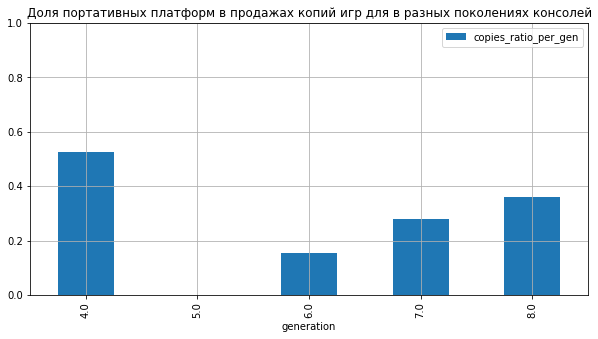

In [24]:
platforms_df.query('portable').groupby('generation')['copies_ratio_per_gen'].agg('sum').plot(
    kind='bar', x='generation', y='copies_ratio_per_gen', figsize=(10,5), ylim=(0,1) )

plt.legend()
plt.grid()
plt.title('Доля портативных платформ в продажах копий игр для в разных поколениях консолей')
plt.show()

Мы видим хорошо знакомый хайп-цикл Гартнера для новых технологий:
* завышенные ожидания от качества игр для портативных платформ 4-ого поколения,
* полное разочарование и потеря интереса в 5-ом поколении платформ - возврат к приставкам,
* начиная с 6-ого поколения возникают уже решения со сбалансированными плюсами и минусами портативных консолей и стабильный рост спроса на них,
* финальное плато должно сильно зависеть от рынка, так как где играть в игры - это образ жизни.  Заметим, что в данная статистика совершенно нетипична для нашего рынка - разделение объемов продаж между PC и консолями в пользу последних!

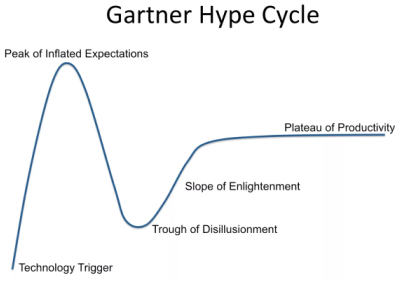

Можем также посмотреть как менялись доли рынка между вендорами:

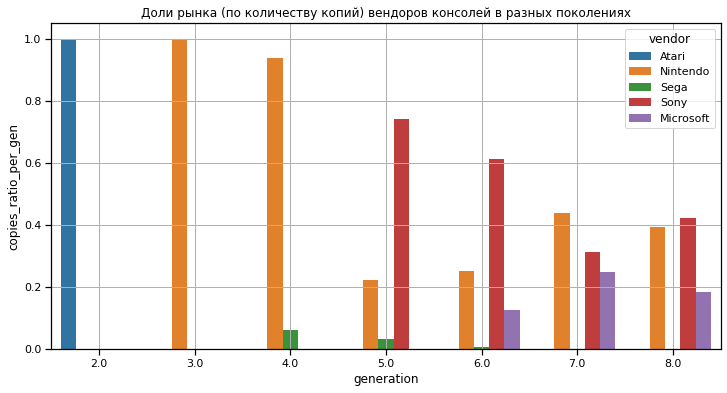

In [25]:
grbyobj = platforms_df.query('vendor == ["Nintendo","Sony","Microsoft","Sega","Atari"]').groupby(
    ['generation','vendor'], as_index=False)['copies_ratio_per_gen'].agg('sum')

plt.figure(figsize=(12, 6))
sns.set_context("notebook")

sns.barplot(data=grbyobj, x='generation', y='copies_ratio_per_gen', hue='vendor')

plt.title('Доли рынка (по количеству копий) вендоров консолей в разных поколениях')
plt.grid()
plt.show()

Будем считать, что на данных двух примерах мы показали огромный аналитический потенциал информации, дополнительно полученной в интернете по аббревиатурам платформ в исходном датафрмчейме и внесенной в platforms_df.  Однако мы не собираемся весь анализ переносить в platforms_df - рациональнее влить допинформацию в исходный датафрейм data_df.  Последний вывод, глядя на platforms_df, касается вендоров платформ - предлагается выбросить Nokia, Bandai, Panasonic и NEC: объемы продаж малы, платформы сегодня неактуальны.

Итак оставим только пятерку лидеров всех времен:
* три современных: Sony, Nintendo и Microsoft;
* два славных героя прошлого: Sega и Atari.

In [26]:
data_df = data_df.merge(platforms_df[['platform','vendor','portable','platform_year','generation']], how='left', on='platform')

In [27]:
data_df['vendor'].value_counts()

Sony         6719
Nintendo     6270
Microsoft    2333
PC-vendor     974
Sega          259
Atari         133
Nokia          12
Bandai          6
Panasonic       3
NEC             3
Name: vendor, dtype: int64

In [28]:
data_df = data_df.query('vendor in ["Sony","Nintendo","Microsoft","PC-vendor","Sega","Atari"]')
data_df.reset_index(drop=True, inplace=True)

In [29]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16688 entries, 0 to 16687
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16688 non-null  object 
 1   platform         16688 non-null  object 
 2   year_of_release  16419 non-null  float64
 3   genre            16688 non-null  object 
 4   na_sales         16688 non-null  float64
 5   eu_sales         16688 non-null  float64
 6   jp_sales         16688 non-null  float64
 7   other_sales      16688 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
 11  total_sales      16688 non-null  float64
 12  vendor           16688 non-null  object 
 13  portable         16688 non-null  bool   
 14  platform_year    15714 non-null  float64
 15  generation       15714 non-null  float64
dtypes: bool(1), float64(9), object(6)
memory usage: 1.9+ MB


На этом обработка столбца platform завершена - добавлены столбцы vendor, portable, platform_year и generation, соответствующие платформам, аббревиатура которых указана в столбце platform. В заключение традиционно посмотрим распределение записей по платформам.  Переменная категорийная - поэтому статистических параметров нет (медиан, квартилей, среднего и дисперсии), Но вместо неинформативного bar-графика по именам платформ гораздо информативнее выглядит гистограмма по поколениям платформ - ее и посмотрим (не зря старались!):

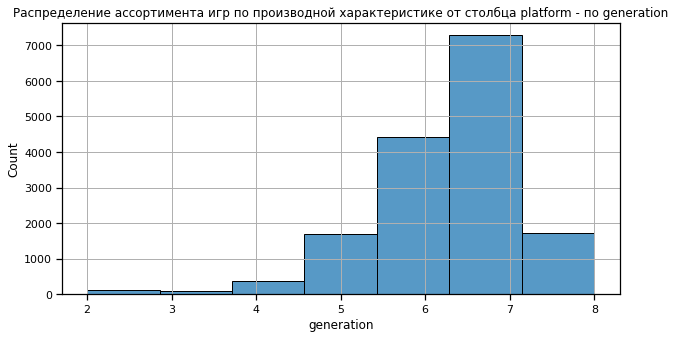

In [30]:
plt.figure(figsize=(10, 5))
sns.set_context("notebook")

sns.histplot(data=data_df, x='generation', bins=7) # у нас представлены поколения платформ от 2 по 8 включительно (bins=7)

plt.title('Распределение ассортимента игр по производной характеристике от столбца platform - по generation')
plt.grid()
plt.show()

Обратим внимание, что это не объемы продаж, а ассортимент - разные игры для разных платформ в каждом из поколений.  Чтобы посмотреть объемы продаж, нужно сгруппировать и просуммировать их:

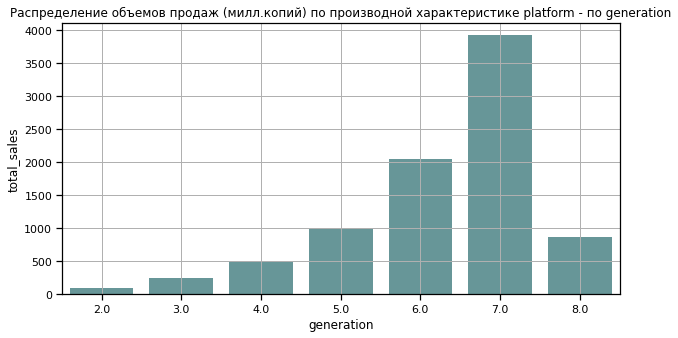

In [31]:
plt.figure(figsize=(10, 5))
sns.set_context("notebook")

sns.barplot(data=data_df.groupby('generation', as_index=False)['total_sales'].agg('sum'), 
            x='generation', y='total_sales', color='cadetblue')

plt.title('Распределение объемов продаж (милл.копий) по производной характеристике platform - по generation')
plt.grid()
plt.show()

Как видим, по какой-то причине продажи 8 поколения сильно отстают от тренда - вплоть до 7 поколения объемы продаж с каждым поколением удваивались.  Середина 2016 года (актуальность данных датасета) как раз приходится на середину периода активных продаж 8-ого поколения: 
* 8-ое поколение стартовало с 2012 года
* 9-ое поколение стартовало с 2019 года

Если бы тренд сохранился, то к нашему времени (2020+) колонка с 8 поколением должна была бы достигнуть порядка 7800 миллионов копий (в среднем у каждого земного жителя была бы одна копия игры из этого магазина!), но показатели полудистанции 8 поколения вызывают сомнения, что тренд сохранится. Возможно уже сказывается насыщение - не хватает покупателей, чтобы обеспечить тренд экстенсивного роста (что, собственно, и есть причина мирового экономического кризиса)

### Столбец `year_of_release`

In [32]:
data_df.query('~(year_of_release > 0.0)') [['name', 'year_of_release', 'platform_year','generation']].head() 
# этим сравнением выбираем NaN, так как внутри конструкции query не распознается ни np.NaN, ни @np.NaN

,name,year_of_release,platform_year,generation
183,Madden NFL 2004,NaN,2000.0,6.0
377,FIFA Soccer 2004,NaN,2000.0,6.0
456,LEGO Batman: The Videogame,NaN,2006.0,7.0
475,wwe Smackdown vs. Raw 2006,NaN,2000.0,6.0
609,Space Invaders,NaN,1978.0,2.0


Кстати, вывод выше подсказывает, что год может быть частью названия игры - сразу заполним часть пробелов, тспользуя эту идею (есть, конечно, риск попасть на фантастику, типа романа Оруэлла "1984", который вышел далеко не в 1984, поэтому добавим еще проверку на год платформы):

In [33]:
def year_fill_line_func2000(df): # заполняет года с 2000
    year = df['year_of_release']
    name = df['name']
    start_of_sales = df['platform_year']  
    interval_of_sales = 7.0 # параметр максимального кол-ва лет продаж платформы (кроме PC) 
    
    if year >= 0.0: return year # заполненные года не меняем
    
    for y in range(2000,2017):
        if str(y) in name:
            if not (start_of_sales >= 0.0): return y # для PC не можем сделать дополнительную проверку
            elif y <= (start_of_sales + interval_of_sales): return y
            else: return year # число, похожее на год в имени игры, не попало в период продаж платформы

def year_fill_line_func(df): # заполняет года до 2000
    year = df['year_of_release']
    name = df['name']
    start_of_sales = df['platform_year']  
    interval_of_sales = 7.0 # параметр максимального кол-ва лет продаж платформы (кроме PC) 
    
    if year > 0.0: return year # заполненные года не меняем
    
    for y in range(80,100):
        if str(y) in name:
            if not (start_of_sales >= 0.0): return y+1900 # для PC не можем сделать дополнительную проверку
            elif (y+1900) <= (start_of_sales + interval_of_sales): return y+1900
            else: return year # число, похожее на год в имени игры, не попало в период продаж платформы            

data_df['year_of_release'] = data_df.apply(year_fill_line_func2000,axis=1)
data_df['year_of_release'] = data_df.apply(year_fill_line_func,axis=1)


In [34]:
data_df.info() # сравним результат - заполнили 19 пробелов!  Не густо!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16688 entries, 0 to 16687
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16688 non-null  object 
 1   platform         16688 non-null  object 
 2   year_of_release  16438 non-null  float64
 3   genre            16688 non-null  object 
 4   na_sales         16688 non-null  float64
 5   eu_sales         16688 non-null  float64
 6   jp_sales         16688 non-null  float64
 7   other_sales      16688 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
 11  total_sales      16688 non-null  float64
 12  vendor           16688 non-null  object 
 13  portable         16688 non-null  bool   
 14  platform_year    15714 non-null  float64
 15  generation       15714 non-null  float64
dtypes: bool(1), float64(9), object(6)
memory usage: 1.9+ MB


Посмотрим сколько из оставшихся 250 записи без года игры вышли на PC (то есть по платформе не получится определить диапазон лет):

In [35]:
data_df[ data_df['year_of_release'].isna() ].query('platform == "PC"')['name'].count()

16

Ну эти 16 можно заполнить и вручную - по названиям в интернете.  И все же заполнять все остальные 250-16=234 годом платформы не хотелось бы.  Но у нас много игр выходило на нескольких платформах - это дает шанс восстановить случайно непроставленный год по записям той же игры для других платформ, где год указан.  Исследуем детальнее эту возможность.

In [36]:
data_df.query('name == "Need for Speed: Most Wanted"')[['name','platform','year_of_release','genre','total_sales','portable',
                                                        'platform_year','generation']] # вернемся к примеру для одного имени:

,name,platform,year_of_release,genre,total_sales,portable,platform_year,generation
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,4.37,False,2000.0,6.0
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,2.81,False,2006.0,7.0
1189,Need for Speed: Most Wanted,X360,2012.0,Racing,1.56,False,2005.0,7.0
1590,Need for Speed: Most Wanted,X360,2005.0,Racing,1.25,False,2005.0,7.0
1997,Need for Speed: Most Wanted,XB,2005.0,Racing,1.04,False,2001.0,6.0
2047,Need for Speed: Most Wanted,PSV,2012.0,Racing,1.01,True,2011.0,8.0
3580,Need for Speed: Most Wanted,GC,2005.0,Racing,0.56,False,2001.0,6.0
5970,Need for Speed: Most Wanted,PC,2005.0,Racing,0.29,False,NaN,NaN
6270,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.27,False,2012.0,8.0
6407,Need for Speed: Most Wanted,DS,2005.0,Racing,0.27,True,2006.0,7.0


Мы видим здесь только две игры - с одним именем, но 2005 и 2012 годов выпуска (игра 2012 "долетела" на WiiU уже в 2013).  Если бы здесь отсутствовали данные о годе выпуска, то минимум до 3 пробелов мы бы восстановили!  Как нам написать реализуемый средствами Пандас алгоритм такого восстановления? 

In [37]:
# сперва нужно определить функцию, которая сможет выделять моды годов в колонке year_of_release - вроде бы есть mode():
data_df.query('name == "Need for Speed: Most Wanted"')['year_of_release'].mode()

0    2005.0
dtype: float64

Весьма странный результат - функция mode() видит только моду 2005 и не видит моды 2012, хотя она очевидна!  В описании mode() сказано: Return the mode(s) of the Series. The mode is the value that appears most often. There can be multiple modes. Always returns Series even if only one value is returned.  

Оставим это на совести реализатора mode(), попробуем выделить моды самостоятельно:

In [38]:
data_df.query('name == "Need for Speed: Most Wanted"').value_counts('year_of_release')

year_of_release
2005.0    7
2012.0    4
2013.0    1
dtype: int64

In [39]:
def my_modes(vc_obj): 
# vc_obj является результатом применения value_counts() к Series - сортировка по убыванию частоты (default)
# например vc_obj = data_df.query('name == "Need for Speed: Most Wanted"').value_counts('year_of_release')
    list_of_modes = []
    for y in vc_obj.index:
        if ((y-1) in list_of_modes) or ((y+1) in list_of_modes): continue # отлавливаем в моду также ее "первые гармоники"
        else: list_of_modes.append(y)
    list_of_modes.sort() # нам нужны моды в порядке возрастания года - для сравнения с годом появления консоли
    return list_of_modes

my_modes( data_df.query('name == "Need for Speed: Most Wanted"').value_counts('year_of_release') )

[2005.0, 2012.0]

Итак, моды выделять научились.

Что теперь можно сделать, если у каждой записи будет такая информация?  Можно сверять для каждой записи без года игры, год из списка мод с годом платформы, и первое значение года из списка, превысившее год появления платформы, будет хорошим вариантом для года игры.  Это не сработает, если платформа PC (для которой нет года появления, как и поколения).  Реализуем теперь все это в виде построчной функции:

In [40]:
def my_modes_line_func(i):
    g_name = data_df.loc[i,'name']
    g_year = data_df.loc[i,'year_of_release']
    if g_year >= 0.0: return g_year # заменяем только NaN
    p_year = data_df.loc[i,'platform_year']
    
    modes_list = my_modes(data_df.query('name == @g_name').value_counts('year_of_release'))

    if modes_list is []: return g_year # на всякий случай
    
    if not (p_year >= 0.0): return g_year # это PC
        
    for y in modes_list:
        if y >= p_year: return y
    
    return g_year # на всякий случай

data_df['year_of_release'] = pd.Series(data_df.index).apply(my_modes_line_func)


In [41]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16688 entries, 0 to 16687
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16688 non-null  object 
 1   platform         16688 non-null  object 
 2   year_of_release  16536 non-null  float64
 3   genre            16688 non-null  object 
 4   na_sales         16688 non-null  float64
 5   eu_sales         16688 non-null  float64
 6   jp_sales         16688 non-null  float64
 7   other_sales      16688 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
 11  total_sales      16688 non-null  float64
 12  vendor           16688 non-null  object 
 13  portable         16688 non-null  bool   
 14  platform_year    15714 non-null  float64
 15  generation       15714 non-null  float64
dtypes: bool(1), float64(9), object(6)
memory usage: 1.9+ MB


осталось незаполненных годов выпуска игр 152 из 269 пробелов изначально! 43.5% уже удалось заполнить **точными** значениями и полностью автоматически!  Остальные заполним менее точно - как год выхода платформы плюс 3 года в среднем (максимум продаж).  Ожидаемая точность +/- 3 года.  Но их все еще слишком много, чтобы заполнять вручную.

In [42]:
def year_simple_line_func(df):
    g_year = df['year_of_release']
    p_year = df['platform_year']
    delay = 3  # параметр "запаздывания" года игры за годом платформы
    
    if g_year >= 0.0: return g_year # меняем только NaN
    
    if not (p_year >= 0.0): return g_year # это PC
    
    return p_year + delay

data_df['year_of_release'] = data_df.apply(year_simple_line_func,axis=1)

In [43]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16688 entries, 0 to 16687
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16688 non-null  object 
 1   platform         16688 non-null  object 
 2   year_of_release  16672 non-null  float64
 3   genre            16688 non-null  object 
 4   na_sales         16688 non-null  float64
 5   eu_sales         16688 non-null  float64
 6   jp_sales         16688 non-null  float64
 7   other_sales      16688 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
 11  total_sales      16688 non-null  float64
 12  vendor           16688 non-null  object 
 13  portable         16688 non-null  bool   
 14  platform_year    15714 non-null  float64
 15  generation       15714 non-null  float64
dtypes: bool(1), float64(9), object(6)
memory usage: 1.9+ MB


Остались все те же 16 пропусков в столбце year_of_release  на платформе PC - заполним их вручную

In [44]:
data_df[data_df['year_of_release'].isna()][['name','platform', 'platform_year']]

,name,platform,platform_year
1130,Call of Duty: Black Ops,PC,NaN
4646,TERA,PC,NaN
6813,BioShock 2,PC,NaN
7204,LEGO Harry Potter: Years 5-7,PC,NaN
7716,Dead Space 3,PC,NaN
7727,Test Drive Unlimited 2,PC,NaN
9473,Street Fighter IV,PC,NaN
9694,Rocksmith,PC,NaN
11940,Dead Island: Riptide,PC,NaN
13547,RollerCoaster Tycoon,PC,NaN


In [45]:
data_df.loc[1130, 'year_of_release'] = 2010 # Call of Duty: Black Ops
data_df.loc[4646, 'year_of_release'] = 2011 # TERA
data_df.loc[6813, 'year_of_release'] = 2010 # BioShock 2
data_df.loc[7204, 'year_of_release'] = 2011 # LEGO Harry Potter: Years 5-7
data_df.loc[7716, 'year_of_release'] = 2013 # Dead Space 3
data_df.loc[7727, 'year_of_release'] = 2011 # Test Drive Unlimited 2
data_df.loc[9473, 'year_of_release'] = 2009 # Street Fighter IV
data_df.loc[9694, 'year_of_release'] = 2011 # Rocksmith
data_df.loc[11940,'year_of_release'] = 2013 # Dead Island: Riptide
data_df.loc[13547,'year_of_release'] = 1999 # RollerCoaster Tycoon
data_df.loc[13655,'year_of_release'] = 2016 # Clockwork Empires
data_df.loc[13764,'year_of_release'] = 2008 # GRID
data_df.loc[14724,'year_of_release'] = 2011 # Battle vs. Chess
data_df.loc[16154,'year_of_release'] = 2010 # WRC: FIA World Rally Championship
data_df.loc[16250,'year_of_release'] = 2015 # Homeworld Remastered Collection
data_df.loc[16421,'year_of_release'] = 2012 # Inversion

In [46]:
data_df['year_of_release'] = data_df['year_of_release'].astype(int) # и вот только теперь мы можем поменять тип на int

In [47]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16688 entries, 0 to 16687
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16688 non-null  object 
 1   platform         16688 non-null  object 
 2   year_of_release  16688 non-null  int32  
 3   genre            16688 non-null  object 
 4   na_sales         16688 non-null  float64
 5   eu_sales         16688 non-null  float64
 6   jp_sales         16688 non-null  float64
 7   other_sales      16688 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
 11  total_sales      16688 non-null  float64
 12  vendor           16688 non-null  object 
 13  portable         16688 non-null  bool   
 14  platform_year    15714 non-null  float64
 15  generation       15714 non-null  float64
dtypes: bool(1), float64(8), int32(1), object(6)
memory usage: 

Наконец-то пробелы в данном столбце полностью заполнены, посмотрим на статистику и распределения

In [48]:
data_df['year_of_release'].describe() # c типом datetime так бы хорошо не получилось! 

count    16688.000000
mean      2006.483881
std          5.892139
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

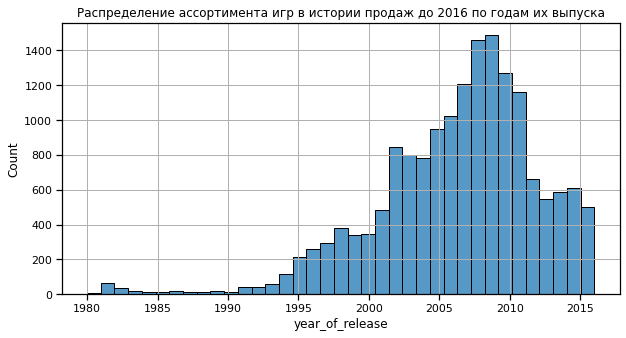

In [49]:
plt.figure(figsize=(10, 5))
sns.set_context("notebook")

sns.histplot(data=data_df, x='year_of_release', bins=2016-1980+1) # 1 bin = 1 год

plt.title('Распределение ассортимента игр в истории продаж до 2016 по годам их выпуска')
plt.grid()
plt.show()

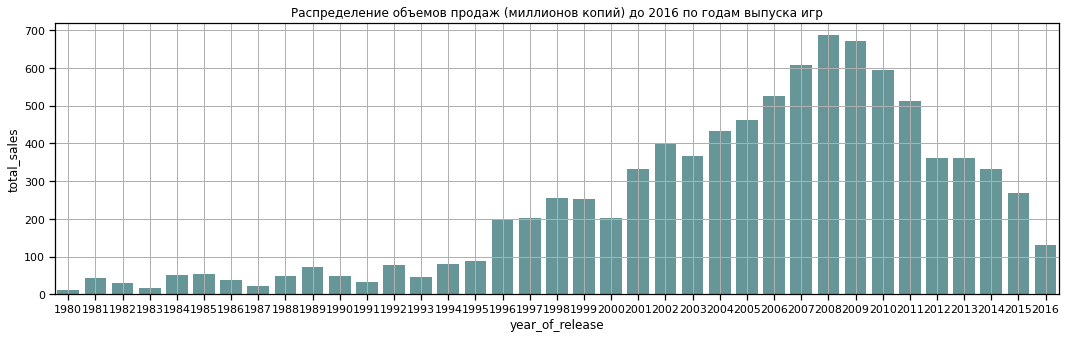

In [50]:
plt.figure(figsize=(18, 5))
sns.set_context("notebook")

sns.barplot(data=data_df.groupby('year_of_release', as_index=False)['total_sales'].agg('sum'), 
            x='year_of_release', y='total_sales', color='cadetblue')

plt.title('Распределение объемов продаж (миллионов копий) до 2016 по годам выпуска игр')
plt.grid()
plt.show()

Казалось бы,  данная картинка распределения продаж по годам более точная, чем распределение продаж по поколениям платформ в прошлой главе, однако это не так - год здесь является, всего-навсего, годом выпуска игры, а ее продажи как раз распределены по всему периоду продаж платформы - то есть охватывают все года данного поколения платформ.  Исключение составляют только игры для PC, которые присутствуют в цифрах на данном графике, но не на графике продаж по поколениям приставок.

### Столбец `genre`

In [51]:
data_df['genre'].value_counts(dropna=False) # сразу смотрим сколько чего, включая нули, если есть 

Action          3369
Sports          2346
Misc            1750
Role-Playing    1493
Shooter         1322
Adventure       1301
Racing          1249
Platform         888
Simulation       872
Fighting         838
Strategy         681
Puzzle           579
Name: genre, dtype: int64

Парамент категорийный - строить его статистику и гистограиммы распределения неуместно.  Максимум графики - это pie.  Однако можно развернуть по годам и увидеть динамику продаж копий разных жанров по годам выпуска игр (NB!: это не продажи по годам!!)

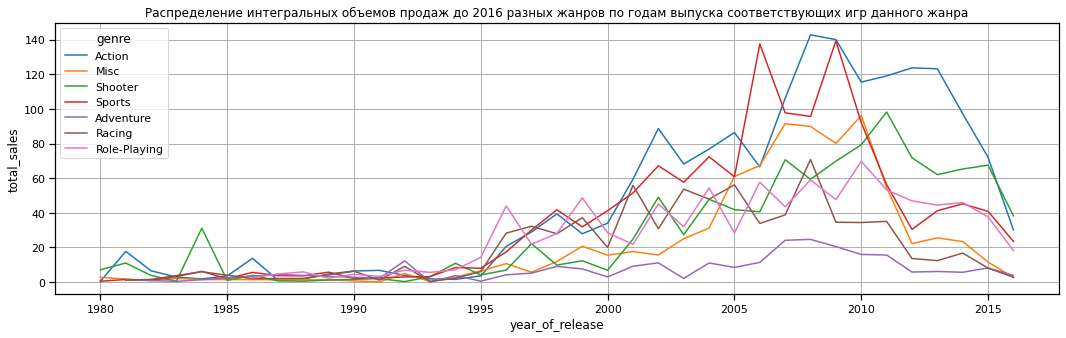

In [52]:
plt.figure(figsize=(18, 5))
sns.set_context("notebook")

sns.lineplot(data=data_df.query('genre in ["Action","Sports","Misc","Role-Playing","Shooter","Adventure","Racing"]').groupby(
    ['year_of_release','genre'], as_index=False)['total_sales'].agg('sum'), x='year_of_release', y='total_sales', hue='genre')

plt.title('Распределение интегральных объемов продаж до 2016 разных жанров по годам выпуска соответствующих игр данного жанра')
plt.grid()
plt.show()

столбец готов к анализу - никакая предобработка не нужна.  Пробелов в данных нет.  Если смотреть не абсолютные а относительные объемы продаж на графике, аналогичном графику выше, то межно увидеть динамику предпочтений рынка.  Но оставим это на главу EDA.

### Столбцы `na_sales`, `eu_sales`, `jp_sales` и `other_sales`

In [53]:
data_df[['na_sales','eu_sales','jp_sales','other_sales','total_sales']].describe()

,na_sales,eu_sales,jp_sales,other_sales,total_sales
count,16688.000000,16688.000000,16688.000000,16688.000000,16688.000000
mean,0.263697,0.145262,0.077552,0.047414,0.533925
std,0.814110,0.503704,0.309064,0.186873,1.549356
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.060000
50%,0.080000,0.020000,0.000000,0.010000,0.170000
75%,0.240000,0.110000,0.040000,0.030000,0.470000
max,41.360000,28.960000,10.220000,10.570000,82.540000


Интересная статистика - в каждом регионе у почти половины игр вообше не продано ни одной копии!  Посмотрим на значение 50% и 75% - они идут с точностью до 0.01 (в самом начале мы смотрели на датафрейм и там тоже цифры продаж были указаны с точностью до 0.01).  Проблема понятна - объемы продаж округлялись до 10000 копий!  Это при том, что у 50% игр объемы продаж в регионах на уровне 80000 (NA), 20000 (EU), менее 5000 (JP) и менее 15000 (Other).  К нашему счастью, по регионам это не совпадает - то есть одна игра может продаваться в одном регионе и не продаваться в другом: 

In [54]:
len( data_df.query('total_sales < 0.01')) # сравним - только 2 нулевых значение по глобальным продажам

2

In [55]:
len( data_df.query('jp_sales < 0.01')) # а теперь посмотрим один регион - полдатасета!!

10512

Так что нам сильно повезло, что несмотря на жуткую идею (не нашу!) округлять данные продаж по играм до 10000 копий, в разных регионах хорошо продаваемые игры разные и у оценки total_sales почти нет нулей!  Данные полные, они будут аггрегироваться в различных исследованиях в главе EDA.  Пока лишь посмотрим гистограмму распределения игр по `total_sales`:

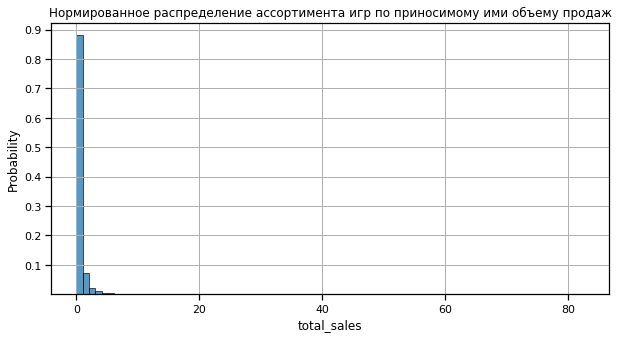

In [56]:
plt.figure(figsize=(10, 5))
plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
sns.set_context("notebook")

sns.histplot(data=data_df, x='total_sales', bins=80, stat='probability') # 1 bin = 1 мил. проданных копий

plt.title('Нормированное распределение ассортимента игр по приносимому ими объему продаж')
plt.grid()
plt.show()

Ожидаемо жутко - но мы знаем, что увеличивать по горизонтали масштаб возле нуля бесполезно - там дельта функция в нуле с существенной долей датасета, и чем меньше мы сделаем bin, тем выше станет пик, пока мы не увеличим разрешение до 0.01 по оси х!

Из данного графика мы можем сказать, что 87% ассортимента игр имеют менее 1 миллиона копий продаж.

### Столбцы `critic_score` и `user_score`

Очень много отсутствующих данных.  В столбце user_score к тому же есть значения tbd, которые гораздо хуже чем NaN, так как не дают считать статистику и делают тип данных object: 

In [57]:
data_df['critic_score'].describe()

count    8136.000000
mean       68.965954
std        13.938153
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [58]:
data_df['user_score'].value_counts(dropna=False).head()

NaN    6675
tbd    2424
7.8     324
8       290
8.2     282
Name: user_score, dtype: int64

Поскольку никаких идей о том, что дополнительно может нам дать информация tbd (сокращение для to be done) для анализа, а вот мешают они конкретно, предлагается переделать их в NaN и поменять тип данных в столбце на float:

In [59]:
def filltbd_line_func(x):
    if str(x) == 'tbd': return np.NaN
    else: return x
    
data_df['user_score'] = data_df['user_score'].apply(filltbd_line_func)

In [60]:
data_df['user_score'] = pd.to_numeric(data_df['user_score'])

In [61]:
data_df[['critic_score','user_score']].describe() # сразу воспользуемся плодами перехода к численному типу данных!

,critic_score,user_score
count,8136.000000,7589.000000
mean,68.965954,7.125260
std,13.938153,1.499989
min,13.000000,0.000000
25%,60.000000,6.400000
50%,71.000000,7.500000
75%,79.000000,8.200000
max,98.000000,9.700000


Визуально статистика рейтинга критики и пользователей похожи - только критики оценивают по 100-бальной шкале, а пользователи по 10-бальной, но с точностью до десятых.  А не проверить, ли нам гипотезу, что в среднем и критики и пользователи оценивают игры одинаково?

#### Проверка гипотезы о совпадении мнений критиков и пользователей

Сперва нужно подготовить выборки записей, где есть оба рейтинга:

In [62]:
scored_df = data_df[ data_df['critic_score'].notna() & data_df['user_score'].notna() ]

In [63]:
scored_df[['critic_score','user_score']].describe() # на пересечении 7016 записей - должна быть точная статистика

,critic_score,user_score
count,7016.000000,7016.000000
mean,70.248005,7.182668
std,13.880800,1.441204
min,13.000000,0.500000
25%,62.000000,6.500000
50%,72.000000,7.500000
75%,80.000000,8.200000
max,98.000000,9.600000


Сформулируем гипотезу для статистического теста:
* $H_0$ - средние этих двух статвеличин совпадают (если user_score домножить на 10)
* $H_1$ - альтернативная гипотеза (средние различны)

и посмотрим статистическую достоверность с которой можно принять данную гипотезу:

In [64]:
array1 = np.array(scored_df['critic_score'])
array2 = np.array(scored_df['user_score']*10)

stat_test_result = st.ttest_rel(array1, array2) # выборки зависимы: каждый sample по одной игре, должна быть сильная корреляция

print('вероятность получить такое расхождение средних выборок =', stat_test_result.pvalue )

вероятность получить такое расхождение средних выборок = 2.7610692377358537e-24


Такую нулевую гипотезу нельзя принять ни при каком разумном доверительном интервале

In [65]:
scored_df[['critic_score','user_score']].corr() # посмотрим еще корреляцию - тоже не ахти!

,critic_score,user_score
critic_score,1.000000,0.581122
user_score,0.581122,1.000000


**Вывод:** и в среднем критики и пользователи оценивают по-разному, и корреляция неожиданно средняя - нет даже одной девятки!  Получается, что рейтинги в принципе различаются и заполнять пробелы одного рейтинга имеющимися значениями другого (с точностью до умножения на 10) нельзя.  

#### Другие варианты заполнения пробелов в рейтингах игр

В таком случае нужны другие идеи заполнения рейтингов.  Самый неточный, но универсальный метод - заполнять средним по жанру в данном поколении игр.  Однако по примеру заполнения year_of_release оставим способ "средней температуры по больнице" на самую последнюю итерацию.  Перед этим попробуем опять посмотреть на рейтинги внутри группы с одним именем игры.  Опять наш пример:

In [66]:
data_df.query('(name == "Need for Speed: Most Wanted")&(year_of_release == 2005)'
             )[['name','platform','year_of_release','genre','portable','generation','critic_score','user_score']]

,name,platform,year_of_release,genre,portable,generation,critic_score,user_score
253,Need for Speed: Most Wanted,PS2,2005,Racing,False,6.0,82.0,9.1
1590,Need for Speed: Most Wanted,X360,2005,Racing,False,7.0,83.0,8.5
1997,Need for Speed: Most Wanted,XB,2005,Racing,False,6.0,83.0,8.8
3580,Need for Speed: Most Wanted,GC,2005,Racing,False,6.0,80.0,9.1
5970,Need for Speed: Most Wanted,PC,2005,Racing,False,NaN,82.0,8.5
6407,Need for Speed: Most Wanted,DS,2005,Racing,True,7.0,45.0,6.1
6470,Need for Speed: Most Wanted,GBA,2005,Racing,True,6.0,NaN,8.3


Как мы видим, внутри подгруппы с одинаковым значением мобильности оценки критиков весьма схожи.  Однако, будучи успешной на приставках, игра может иметь существенно меньший успех на портитивных устройствах.  Немного сбивает с толку, что в пограничные года - например в нашем случае 2005 - последний год для 6-ого поколения - в платформы начинают входить 7-ое поколение.  Однако в целом можно попытаться заполнить пробелы рейтингов средним по имени и поколению платформы.  Посмотим, насколько это увеличит заполненность рейтингов:

In [67]:
data_df['avg_critic_score'] = data_df.groupby(['name','generation','portable'])['critic_score'].transform('mean')

In [68]:
data_df['avg_user_score'] = data_df.groupby(['name','generation','portable'])['user_score'].transform('mean')

In [69]:
print('Подход замены рейтингов по среднему в подгруппе (имя + поколение + мобильность) позволит:')
print('заполнить отсутствующих critic_scores:', len(data_df[ data_df['critic_score'].isna() & data_df['avg_critic_score'].notna() ]) )
print('заполнить отсутствующих user_scores:', len(data_df[ data_df['user_score'].isna() & data_df['avg_user_score'].notna() ]) )

Подход замены рейтингов по среднему в подгруппе (имя + поколение + мобильность) позволит:
заполнить отсутствующих critic_scores: 247
заполнить отсутствующих user_scores: 427


In [70]:
data_df['critic_score'].fillna(data_df['avg_critic_score'], inplace=True)
data_df['user_score'].fillna(data_df['avg_user_score'], inplace=True)
data_df[['critic_score','user_score']].describe()

,critic_score,user_score
count,8383.000000,8016.000000
mean,68.804127,7.105994
std,14.026945,1.506566
min,13.000000,0.000000
25%,60.000000,6.400000
50%,71.000000,7.500000
75%,79.000000,8.200000
max,98.000000,9.700000


Точным способом заменилось только 674 нулей, так как группировки были очень мелкие и вероятность получить внутри одной группы и NaN и ненули была не так велика.  Остается вариант расширить группировки, за счет снижения точности - например, вместо (имя + поколение + мобильность)  взять группировку по (жанр + поколение).  То есть поменять нули на средние рейтинги жанров в каждом из поколений, но тогда половина записей будет распределена между 12\*7 = 84 дельта-функциями распределения с пиковыми значениями в средних по жанру для каждого поколения.  Можно взять группировки (жанр + платформа) - это увеличит кол-во дельта-функций до 12\*26 = 312 и при 1 bin = 5 score points есть надежда, что гистограммы будут выглядеть достаточно ровно.  И все же у меня сомнения, что так стоит делать - все аналитические вопросы проекта касаются сравнения относительных величин: 
* Самые популярные платформы (топ-5). 
* Самые популярные жанры (топ-5).
* Средние пользовательские рейтинги платформ Xbox One и PC - одинаковые?
* Средние пользовательские рейтинги жанров Action и Sports - разные?

Ответы на все эти вопросы одинаковы и на текущем неполном рейтинге, и на рейтинге с пробелами заполненными по группам (жанр + платформа), единственная разница в кажущейся большей точности при меньших пробелах, но эта точность иллюзорна - мы просто экстарполировали выборку ненулевых значений некоторым волюнтаристским (хоть и логичным) способом!  На все эти вопросы можно ответить и на текущих неполных данных рейтинга.

Поэтому пока что не будем продолжать заполнять пробелы в рейтингах критиков и пользователей.  Единственная идея еще - введем столбец с усредненным рейтингом - среднее между critic_score и user_score\*10:

In [71]:
data_df.drop(columns=['avg_critic_score','avg_user_score'], inplace=True) # эти столбцы более не нужны

In [72]:
def score_line_func(df):
    cr = df['critic_score']
    us = df['user_score']
    
    if (not (cr >= 0.0)) and (not (us >= 0.0)): return np.NaN # оба NaN
    
    if (not (cr >= 0.0)): return 10*us # если один NaN, возвращается второй рейтинг
    if (not (us >= 0.0)): return cr

    return (cr + 10*us)/2.0

data_df['score'] = data_df.apply(score_line_func, axis=1)

In [73]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16688 entries, 0 to 16687
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16688 non-null  object 
 1   platform         16688 non-null  object 
 2   year_of_release  16688 non-null  int32  
 3   genre            16688 non-null  object 
 4   na_sales         16688 non-null  float64
 5   eu_sales         16688 non-null  float64
 6   jp_sales         16688 non-null  float64
 7   other_sales      16688 non-null  float64
 8   critic_score     8383 non-null   float64
 9   user_score       8016 non-null   float64
 10  rating           9948 non-null   object 
 11  total_sales      16688 non-null  float64
 12  vendor           16688 non-null  object 
 13  portable         16688 non-null  bool   
 14  platform_year    15714 non-null  float64
 15  generation       15714 non-null  float64
 16  score            8922 non-null   float64
dtypes: bool(1), 

К сожалению наличие рейтингов критиков и пользователей совпадало на (примерно) 90%, поэтому использование среднего рейтинга увеличивает выборку только на (примерно) 10%.  Но усредненный рейтинг критиков и пользователей имеет свой смысл, поэтому столбец оставляем.  В итоге будет ценнее для анализа привести все рейтинги к общей шкале от 0 до 100.

In [74]:
data_df['user_score'] = data_df['user_score']*10 # приведем к одной шкале оценки все рейтинги
data_df[['critic_score','score','user_score']].describe()

,critic_score,score,user_score
count,8383.000000,8922.000000,8016.000000
mean,68.804127,69.216319,71.059943
std,14.026945,13.540411,15.065662
min,13.000000,0.000000,0.000000
25%,60.000000,62.000000,64.000000
50%,71.000000,71.500000,75.000000
75%,79.000000,79.000000,82.000000
max,98.000000,97.000000,97.000000


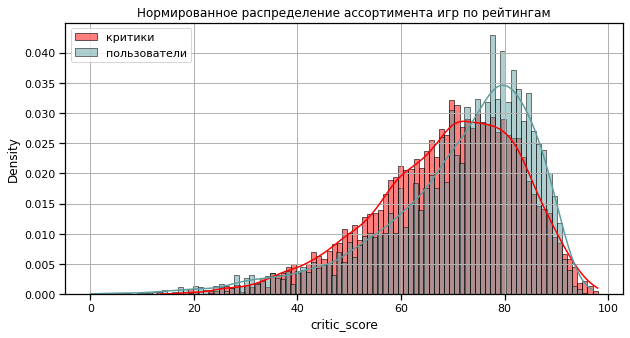

In [75]:
plt.figure(figsize=(10, 5))
sns.set_context("notebook")

cax = sns.histplot(data=data_df, x='critic_score', bins=86, stat='density', kde=True, color='red', label='критики')

sns.histplot(ax=cax, data=data_df, x='user_score', bins=98, stat='density', kde=True, color='cadetblue', label='пользователи')

plt.title('Нормированное распределение ассортимента игр по рейтингам')
plt.legend()
plt.grid()
plt.show()

Поскольку кол-во ненулевых значений разное, то корректно смотреть и сравнивать нормированное распределение.

Как видно визуально, мнения критиков более умеренные и имеют более широкий диапазон, тогда как у пользователей доминируют эмоции от пережитого опыта игры, и они склонны более категорично выделять свои субъективные предпочтения - распределение уже и пик правее.

В завершение проверим еще одну идею - не является ли отсутствие рейтингов результатом нулевых продаж игр (в каком-то регионе)?

In [76]:
lim = 0.01 # отсечка округления данных о продажах
print('Доля отсутствия рейтингов среди игр с продажей менее', lim, 'равна:')

print('EU:', round(100*data_df.query('eu_sales < @lim')['score'].isna().sum()/len( data_df.query('eu_sales < @lim')),2),'%')
print('NA:', round(100*data_df.query('na_sales < @lim')['score'].isna().sum()/len( data_df.query('na_sales < @lim')),2),'%')
print('JP:', round(100*data_df.query('jp_sales < @lim')['score'].isna().sum()/len( data_df.query('jp_sales < @lim')),2),'%')
print('Other:', round(100*data_df.query('other_sales < @lim')['score'].isna().sum()/len( data_df.query('other_sales < @lim')
                                                                                       ),2),'%')

Доля отсутствия рейтингов среди игр с продажей менее 0.01 равна:
EU: 74.39 %
NA: 83.31 %
JP: 36.07 %
Other: 69.11 %


Похоже, что так: причиной отсутствия остальных рейтингов является то, что для игр с малой статистикой продаж их просто не трудились собирать. 

### Столбец `rating`

Есть некоторая путаница из серии ложных друзей переводчика:
* слова "скор" в русском языке нет, score переводится как рейтинг
* как же нам перевести теперь rating, чтобы различать их?

Как гласит разъяснение, "Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию."  Ну так и будем переводить как "категория контента".  Итак, посмотрим, какие есть категории для игрового контента у ESRB:

In [77]:
data_df['rating'].value_counts()

E       3989
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Смотрим в интернете значения аббревиатур ESRB:
* `E    -` для всех от 6 лет
* `T    -` для подростков
* `M    -` для совершеннолетних
* `E10+ -` для всех от 10 лет
* `EC   -` для маленьких
* `RP   -` в ожидании присвоения рейтинга
* `K-A  -` для всех от 6 лет (старая версия обозначения)
* `AO   -` только для взрослых (секс и насилие)

**Выводы:**
* RP меняем на NaN, 
* K-A переименовываем в E, 
* а вот по AO и EC есть сильное желение их выкинуть или не смотреть, как аутсайдеров статистики по категории контента. Посмотрим их вклад в продажи:

In [78]:
data_df.query('rating in ["EC","AO"]')[['name','platform','year_of_release','genre','score','rating','total_sales',
                                        'generation','portable']]

,name,platform,year_of_release,genre,score,rating,total_sales,generation,portable
874,Grand Theft Auto: San Andreas,XB,2005,Action,89.5,AO,1.96,6.0,False
4295,Nickelodeon Team Umizoomi,DS,2011,Action,NaN,EC,0.45,7.0,True
5032,Sesame Street: Elmo's A-to-Zoo Adventure,Wii,2010,Misc,NaN,EC,0.37,7.0,False
6044,Sesame Street: Cookie's Counting Carnival,Wii,2010,Misc,NaN,EC,0.29,7.0,False
6759,Dora the Explorer: Journey to the Purple Planet,PS2,2005,Adventure,70.0,EC,0.24,6.0,False
7578,"Ni Hao, Kai-lan: New Year's Celebration",DS,2009,Misc,NaN,EC,0.20,7.0,True
9947,Dora the Explorer: Journey to the Purple Planet,GC,2005,Adventure,70.0,EC,0.11,6.0,False
13048,Sesame Street: Cookie's Counting Carnival,PC,2010,Misc,NaN,EC,0.05,NaN,False
13438,Sesame Street: Elmo's A-to-Zoo Adventure,PC,2010,Misc,NaN,EC,0.04,NaN,False


Выкидывать GTA было бы странно.  Но и как единственный представитель категории контента для взрослых она не полезна.

**Решение:*
* переименовываем AO в M (к совершеннолетним)
* переименовываем EC в T (к подросткам)

Остается 4 категории контента с крупными выборками.

In [79]:
def content_line_func(df):
    content = df['rating']
    
    if content == 'RP': return
    if content == 'K-A': return 'E'
    if content == 'AO': return 'M'
    if content == 'EC': return 'T'
    
    return content

data_df['rating'] = data_df.apply(content_line_func, axis=1)

In [80]:
data_df['rating'].value_counts(dropna=False)

NaN     6743
E       3992
T       2969
M       1564
E10+    1420
Name: rating, dtype: int64

Заполним частично пробелы по группировке по имени игры (по жанру нет смысла усреднять контент):

In [81]:
data_df['rating'].fillna('Z', inplace=True) # временно - чтобы работало сравнение min в следующей команде

In [82]:
data_df['avg_rating'] = data_df.groupby(['name','portable'])['rating'].transform('min')

In [83]:
def return_nan_line_func(s): # я полюбил работать с NaN
    if s == 'Z': return np.NaN
    else: return s

data_df['rating'] = data_df['rating'].apply(return_nan_line_func)
data_df['avg_rating'] = data_df['avg_rating'].apply(return_nan_line_func)

In [84]:
data_df[data_df['name'] == 'Need for Speed: Most Wanted'][['name','platform','year_of_release','genre','generation','portable',
                                                             'rating','avg_rating']] # визуально убедимся чем заполняются NaN

,name,platform,year_of_release,genre,generation,portable,rating,avg_rating
253,Need for Speed: Most Wanted,PS2,2005,Racing,6.0,False,T,T
523,Need for Speed: Most Wanted,PS3,2012,Racing,7.0,False,NaN,T
1189,Need for Speed: Most Wanted,X360,2012,Racing,7.0,False,T,T
1590,Need for Speed: Most Wanted,X360,2005,Racing,7.0,False,T,T
1997,Need for Speed: Most Wanted,XB,2005,Racing,6.0,False,T,T
2047,Need for Speed: Most Wanted,PSV,2012,Racing,8.0,True,NaN,E
3580,Need for Speed: Most Wanted,GC,2005,Racing,6.0,False,T,T
5970,Need for Speed: Most Wanted,PC,2005,Racing,NaN,False,T,T
6270,Need for Speed: Most Wanted,WiiU,2013,Racing,8.0,False,NaN,T
6407,Need for Speed: Most Wanted,DS,2005,Racing,7.0,True,E,E


In [85]:
data_df['avg_rating'].value_counts(dropna=False)

NaN     6449
E       4140
T       2991
M       1650
E10+    1458
Name: avg_rating, dtype: int64

Удалось заполнить 294 отсутствовавшие категории контента, причем добавилось во всех 4-х основных категориях!  Результат хорош своей честностью и точностью!  Жаль не многочисленен!  Далее можно было бы просто выбросить столбец rating и переименовать в него столбец avg_rating, но на всякий случай поменаяем только NaN в столбце rating (вдруг мнение ESRB где-то разошлось по платформам!):

In [86]:
def rating_fillna_line_func(df):
    old = df['rating']
    new = df['avg_rating']

    if str(old) == 'nan': return new 
    else: return old
    
data_df['rating'] = data_df.apply(rating_fillna_line_func,axis=1)

In [87]:
data_df['rating'].value_counts(dropna=False)

NaN     6449
E       4089
T       3052
M       1646
E10+    1452
Name: rating, dtype: int64

Не зря предприняли дополнительные усилия - полное совпадение с avg_rating только по кол-ву NaN !  Дальше заполнять этот столбец невозможно - будем делать выводы о распределении категорий контента по другим параметрам по неполной выборке. 

In [88]:
data_df.drop(columns='avg_rating', inplace=True) # далее этот столбец не нужен

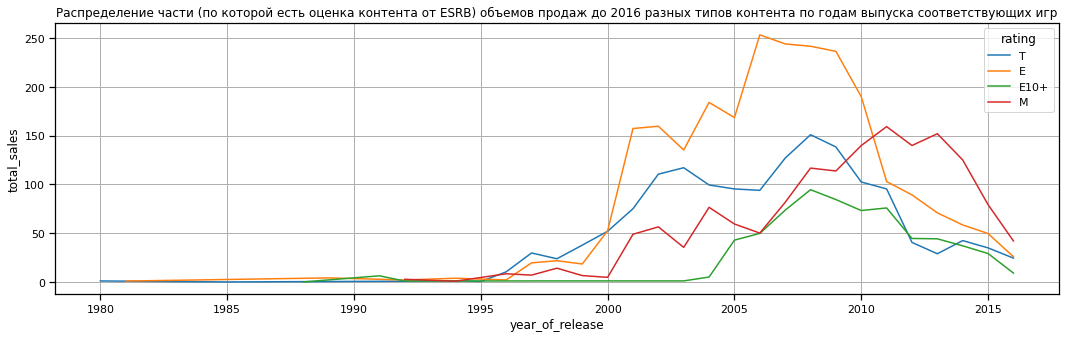

In [89]:
plt.figure(figsize=(18, 5))
sns.set_context("notebook")

sns.lineplot(data=data_df.groupby(['year_of_release','rating'], as_index=False)['total_sales'].agg('sum'), 
             x='year_of_release', y='total_sales', hue='rating')

plt.title('Распределение части (по которой есть оценка контeнта от ESRB) объемов продаж до 2016 разных типов контента по годам выпуска соответствующих игр')
plt.grid()
plt.show()

## Предобработка проведена.  Данные готовы к анализу

In [90]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16688 entries, 0 to 16687
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16688 non-null  object 
 1   platform         16688 non-null  object 
 2   year_of_release  16688 non-null  int32  
 3   genre            16688 non-null  object 
 4   na_sales         16688 non-null  float64
 5   eu_sales         16688 non-null  float64
 6   jp_sales         16688 non-null  float64
 7   other_sales      16688 non-null  float64
 8   critic_score     8383 non-null   float64
 9   user_score       8016 non-null   float64
 10  rating           10239 non-null  object 
 11  total_sales      16688 non-null  float64
 12  vendor           16688 non-null  object 
 13  portable         16688 non-null  bool   
 14  platform_year    15714 non-null  float64
 15  generation       15714 non-null  float64
 16  score            8922 non-null   float64
dtypes: bool(1), 

# Исследовательский анализ данных (EDA)

## Исследование: выпуск ассортимента игр по годам их производства

Данное исследование запрошено для принятия решения, как адресовать временной аспект в статистике продаж, и по какому принципу выделять период(ы) важный(е) для прогноза продаж на будущий (2017) год.  Частично данный вопрос уже затрагивался во время преобработки данных - соберем ниже всю логику в одном месте не боясь что-то повторить. 

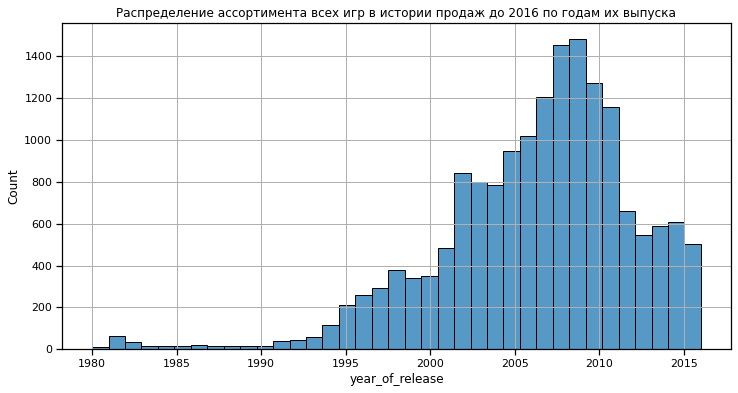

In [91]:
plt.figure(figsize=(12, 6))
sns.set_context("notebook")

sns.histplot(data=data_df, x='year_of_release', bins=2016-1980+1) # 1 bin = 1 год

plt.title('Распределение ассортимента всех игр в истории продаж до 2016 по годам их выпуска')
plt.grid()
plt.show()

Количество bins подобрано так, чтобы было соответствие 1 bin = 1 год выпуска игр.

Мы наблюдаем, что начиная с пятого поколения максимальное производство игр приходится на середину периода жизни поколения платформ, а минимумы - на годы смены поколений платформ (новые игры уже планируются к выпуску на новых платформах, так как выпуск игры на старой платформе потенциально снижает кол-во лет активных продаж игры, соответственно игра приносит меньше прибыли продъюсерам/инвесторам):
* 5-ое поколение - максимум производства игр в 1998,
* 6-ое поколение - максимум производства игр в 2002-2003,
* 7-ое поколение - максимум производства игр в 2008-2009,
* ожидается для 8-ого поколения - максимум производства игр в 2016-2017,

Почему же на графике мы не видим никакого максимума в 2016, а наоборот минимум.  Дело в том, что датафрейм содержит только данные продаж, а не всех выпущенных игр.  Таким образом статистика по поколению набирается в этом датафрейме только к окончанию поколения.  Таким образом, мы предполагаем, что актуальные цифры по 8-ому поколению будут не раньше 2020 года, а задача прогнозирования в данном проекте как раз и состоит в их прогнозе и в пересчете на задачи 2017 года. 

Поэтому кривая распределения игр по годам их производства неизбежно имеет взлеты и падения с цикличностью поколения платформ.  Если посмотреть в развертке по поколениям платформ, то картина будет более регулярной, но сбда не попадут игры для PC, так как по PC нет привязки к поколению платформы.  В отношении падения цифр в 8-ом поколении разъяснение то же самое (см. выше):

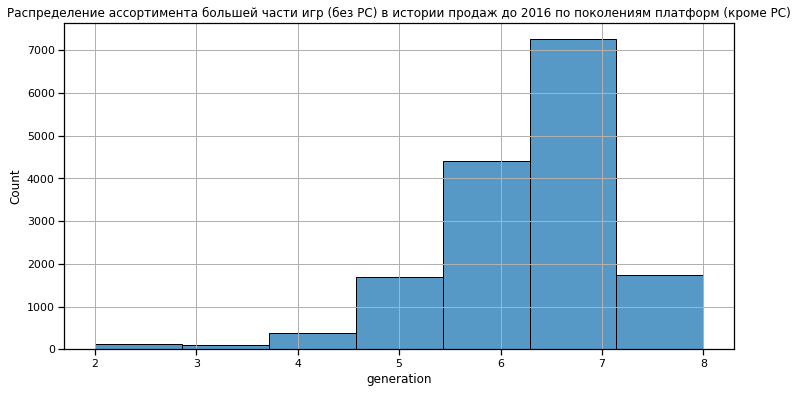

In [92]:
plt.figure(figsize=(12, 6))
sns.set_context("notebook")

sns.histplot(data=data_df, x='generation', bins=7) # 1 bin = 1 поколение со 2-ого по 8-ое

plt.title('Распределение ассортимента большей части игр (без PC) в истории продаж до 2016 по поколениям платформ (кроме PC)')
plt.grid()
plt.show()

Давайте прямо посмотрим корреляцию между годами производства игр и годами выхода платформ:

In [93]:
data_df[['year_of_release','platform_year']].corr()

,year_of_release,platform_year
year_of_release,1.000000,0.924137
platform_year,0.924137,1.000000


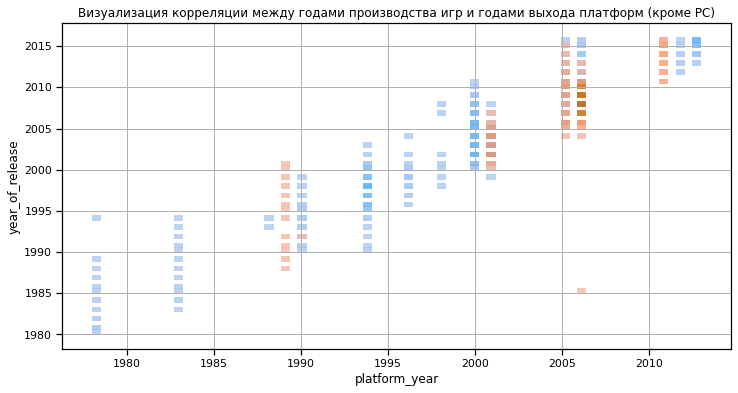

In [94]:
plt.figure(figsize=(12, 6))
sns.set_context("notebook")

cax = sns.histplot(data=data_df, x='platform_year', y='year_of_release', hue='portable', alpha=0.8, legend=False) 
# sns.move_legend(cax, "upper left") # странно, в описании seaborn API данная функция есть, а в версии нашего seaborn нет!

plt.title('Визуализация корреляции между годами производства игр и годами выхода платформ (кроме PC)')
plt.grid()
plt.show()

Голубым показаны приставки, оранжевым - портативные устройства.

На этом графике отчетливо видны поколения платформ с вариацией +\- один год (за исключением попыток Sega и Nintendo плыть против течения в период 1995-1999.  Также видно как производство игр начинается за год до выпуска платформ и растет до начала следующего поколения, потом спадает (быстрее чем росло). То есть, распределение годов выпуска игр по поколению скошено вправо - возможно из-за задержек с выходом игр, а также с уменьшением рисков успеха игры (хоть кол-во годов активных продаж и малое, но предсказуемость успеха выше - синица в руках лучше журавля в небе для невенчурного инвестора!)

Два небольших выброса годов игр во втором и в седьмом поколениях, скорее всего, вызваны автозаполнением года игры - ошибка логики по какой-то причине: например, предположения, что 86 или 94 в названии означали сезон выхода игры (как у спортивных симуляторов), а не Оруэлловское 1984!

### Выводы из исследования:

Проанализированная динамика выпуска ассортимента по годам демонстрирует сильную корреляцию (с коэффициентом 0.924) с годами выхода платформ, под которые они писались. Поэтому в распределении игр по годам выпуска присутствуют моды, соответствующие разным поколениям платформ. Данные моды делают неравномерными многие распределения параметров по годам выпуска игр - присутствуют волнообразности с "длиной волны" в одно поколение. Из чего следует наша рекоментация рассматривать временную динамику не по годам выпуска игр, а по поколениям платформ - так как моды сильно замешиваются, а "судьба" в текущий "актуальный" период у них разная!

## Исследование: объемы продаж игр для тройки платформ-лидеров по годам их производства.

Данное исследование заменяет исследование годовых продаж игр - так как у нас нет объемов продаж по годам, а приписывать все продажи одной игры на протяжении 5-10 лет только одному году не здорово!

In [95]:
data_df.groupby('platform', as_index=False)['total_sales'].agg(['count','sum']).sort_values(by='sum',ascending=False).merge(
    platforms_df[['platform','vendor','portable','generation','platform_year']], how='left', on='platform') 
# посмотрим на лидеров продаж и добавим другие характеристики платформ - чтобы сравнивать подобное с подобным

,platform,count,sum,vendor,portable,generation,platform_year
0,PS2,2161,1255.77,Sony,False,6.0,2000.0
1,X360,1262,971.42,Microsoft,False,7.0,2005.0
2,PS3,1330,939.65,Sony,False,7.0,2006.0
3,Wii,1320,907.51,Nintendo,False,7.0,2006.0
4,DS,2151,806.12,Nintendo,True,7.0,2006.0
5,PS,1197,730.86,Sony,False,5.0,1994.0
6,GBA,822,317.85,Nintendo,True,6.0,2001.0
7,PS4,392,314.14,Sony,False,8.0,2013.0
8,PSP,1209,294.05,Sony,True,7.0,2005.0
9,PC,974,259.52,PC-vendor,False,NaN,NaN


Из данной таблицы возникает следующая идея сравнения тройки лидеров:
1. Сперва посмотреть межвендорную тройку лидеров Sony, Nintendo и Microsoft.  При этом для корректности сравнения следует взять платформы одного поколения и одинаковой портативности:
 * в классе приставок это будет 7-ое поколение PS3, Wii и X360 соответственно,
 * а в классе портативных устройств это будут только PSP (Sony) и DS (Nintendo), оба также 7-ого поколения, а вот Microsoft в портативном сегменте не представлен (исключая мобильные устройства с MS Windows - которые мы не можем вычленить в нашем датафрейме)
2. Затем для каждого лидера посмотреть три поколения 5-6-7 однотипных платформ (приставок):
 * для Sony - PS, PS2 и PS3, 
 * для Nintendo - N64, GC и Wii,
 * для Микрософт - XB и X360 (в пятом поколении не представлен даже среди приставок - удавное влияние бизнеса для PC)
 
 Приступим к реализации данной идеи:

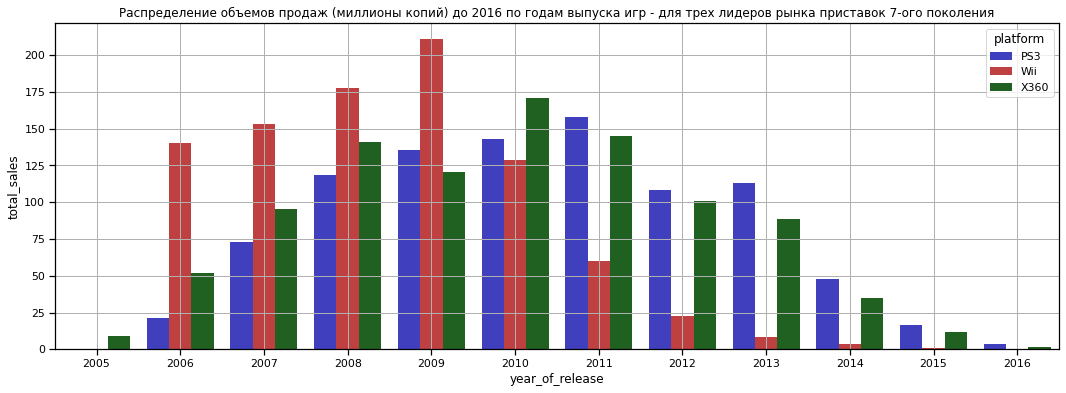

In [96]:
# три лидера, седьмое поколение приставок

plt.figure(figsize=(18, 6))
sns.set_context("notebook")

sns.barplot(data=data_df.query('platform in ["PS3","Wii","X360"]').groupby(['platform','year_of_release'], as_index=False
    )['total_sales'].agg('sum'), x='year_of_release', y='total_sales', hue='platform', palette=['blue','red','green'], saturation=0.5)

plt.title('Распределение объемов продаж (миллионы копий) до 2016 по годам выпуска игр - для трех лидеров рынка приставок 7-ого поколения')
plt.grid()
plt.show()

Еще раз напомним, что это не столько предпочтения покупателей в конкретный год, сколько воплотившийся прогноз производителей игр:  данный график не показывает, что после 2011 года покупатели стали меньше покупать игры для 7-ого поколения, он показывает, что после этого года производители стали преимущественно ориентироваться на 8-ое поколение платформ в производстве новых игр.  Напомним, что абсолютным лидером продаж оказалась PS2 шестого поколения!

Мы также можем увидеть разную GtM стратегию у производителей игр под разные платформы: для Nintendo производители игр делают ставку на опережение и захватывают рынок нового поколения первыми.  В то время как для Sony и Microsoft производители игр еще добирают ревеню на платформе прошлого поколения не спеша осваивая новое - это хорошо видно в таблице платформ для предыдущего поколения - Nintendo 6-ого поколения в самом низу продаж, а Sony 6-ого поколения по прежнему на самом топе - спустя 15 лет с появления платформы!  Это при том, что полные продажи между 6-ым и 7-ым поколениями почти удвоились:

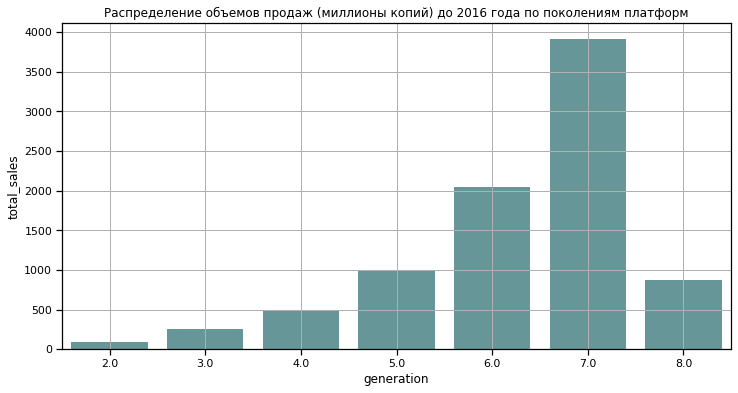

In [97]:
plt.figure(figsize=(12, 6))
sns.set_context("notebook")

sns.barplot(data=data_df.groupby('generation', as_index=False)['total_sales'].agg('sum'), 
            x='generation', y='total_sales', color='cadetblue')

plt.title('Распределение объемов продаж (миллионы копий) до 2016 года по поколениям платформ')
plt.grid()
plt.show()

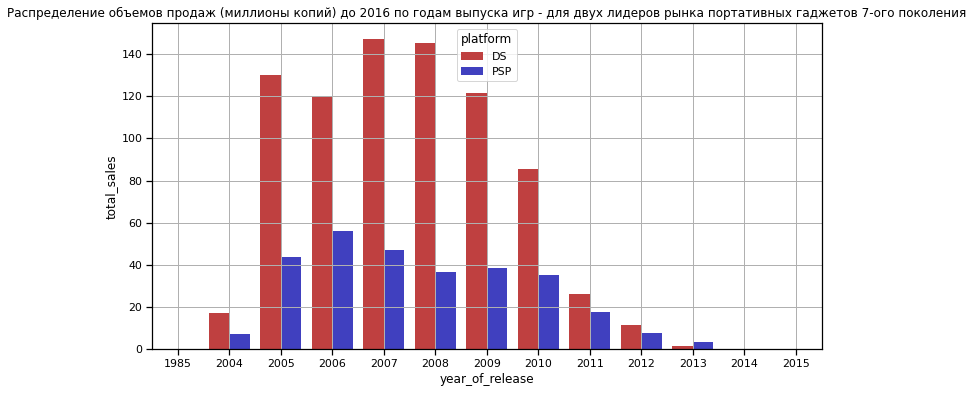

In [98]:
# теперь то же в сегменте портативных приставок

plt.figure(figsize=(12, 6))
sns.set_context("notebook")

sns.barplot(data=data_df.query('platform in ["PSP","DS"]').groupby(['platform','year_of_release'], as_index=False
    )['total_sales'].agg('sum'), x='year_of_release', y='total_sales', hue='platform', palette=['red','blue'], saturation=0.5)

plt.title('Распределение объемов продаж (миллионы копий) до 2016 по годам выпуска игр - для двух лидеров рынка портативных гаджетов 7-ого поколения')
plt.grid()
plt.show()

Тут доминирование Nintendo (возможно блягодаря только японскому рынку) очевидное.  Тренд GtM на атаку в первой половине периода также отчетливо виден - со временем Sony догоняет и обгоняет по производству игр (но не по продаже в год - у Nintendo логика железная: чем раньше выпустим игры, тем больше успеем продать копий пока платформа не устарела)

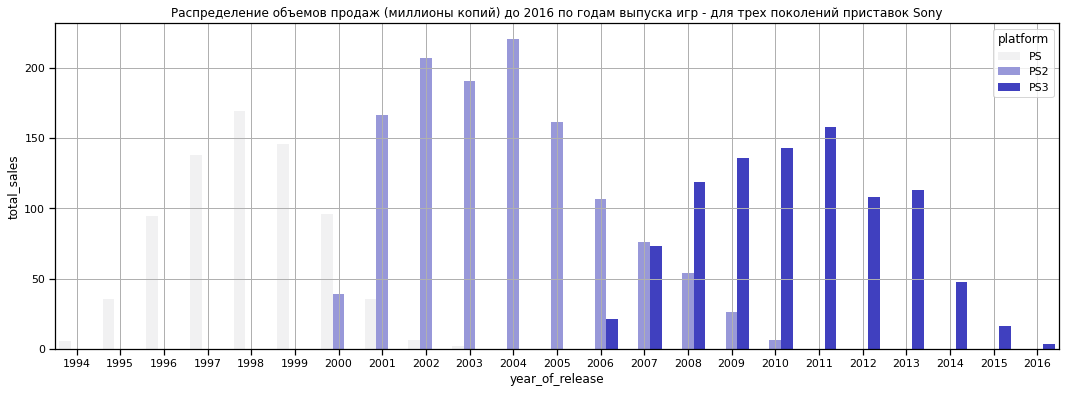

In [99]:
# теперь посмотрим на три поколения приставок 5-6-7 одного вендора

plt.figure(figsize=(18, 6))
sns.set_context("notebook")

sns.barplot(data=data_df.query('platform in ["PS3","PS2","PS"]').groupby(['platform','year_of_release'], as_index=False
    )['total_sales'].agg('sum'), x='year_of_release', y='total_sales', hue='platform', color='blue', saturation=0.5,
           hue_order=['PS','PS2','PS3'])

plt.title('Распределение объемов продаж (миллионы копий) до 2016 по годам выпуска игр - для трех поколений приставок Sony')
plt.grid()
plt.show()

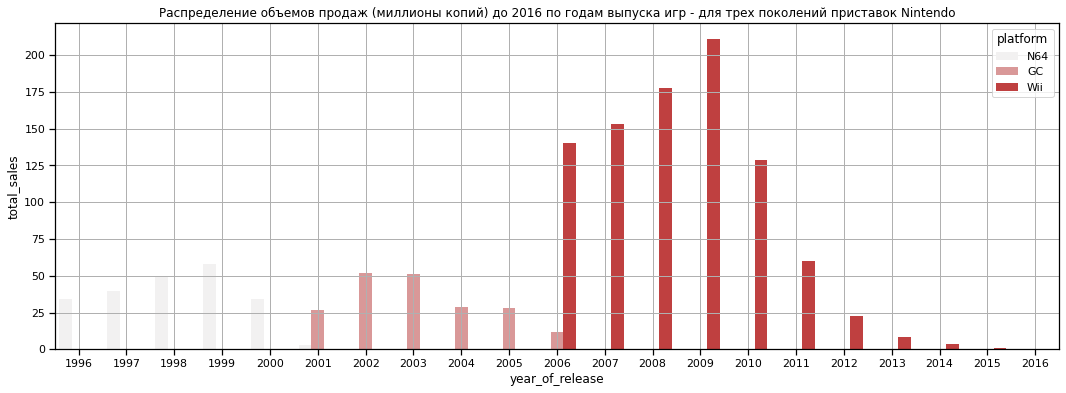

In [100]:
plt.figure(figsize=(18, 6))
sns.set_context("notebook")

sns.barplot(data=data_df.query('platform in ["N64","GC","Wii"]').groupby(['platform','year_of_release'], as_index=False
    )['total_sales'].agg('sum'), x='year_of_release', y='total_sales', hue='platform', color='red', saturation=0.5, 
            hue_order=["N64","GC","Wii"])

plt.title('Распределение объемов продаж (миллионы копий) до 2016 по годам выпуска игр - для трех поколений приставок Nintendo')
plt.grid()
plt.show()

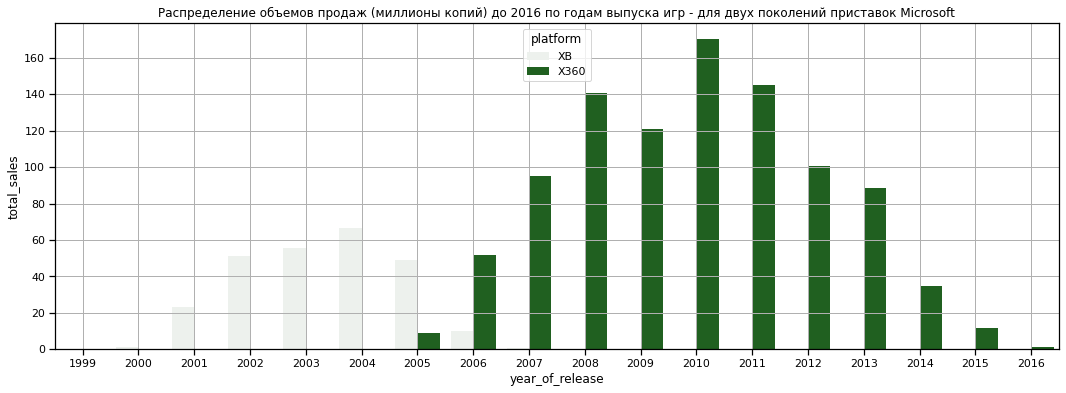

In [101]:
plt.figure(figsize=(18, 6))
sns.set_context("notebook")

sns.barplot(data=data_df.query('platform in ["XB","X360"]').groupby(['platform','year_of_release'], as_index=False
    )['total_sales'].agg('sum'), x='year_of_release', y='total_sales', hue='platform', color='green', saturation=0.5, 
            hue_order=["XB","X360"] )

plt.title('Распределение объемов продаж (миллионы копий) до 2016 по годам выпуска игр - для двух поколений приставок Microsoft')
plt.grid()
plt.show()

### Выводы из исследования

1. Продажи игр под одну платформу определенного поколения продолжается порядка 10-11 лет (+/- год идет за счет подгонки производителями дат выхода - к концу года или к началу).  
2. Пики продаж достигаются для ассортимента игр производства в середине этого периода - практически за один-два года до появления следующего поколения той же платформы 
3. Таким образом, распределение продаж имеет пирамидальную форму, 
 * причем левый склон пирамиды имеет явную выпуклость вверх - что отражает как желание продьюсеров увеличить срок активных продаж сдвигом года выпуска игры к началу срока платформы, так и, собственно, результирующий более продолжительный срок продаж игр на левом склоне, по сравнению с правым
 * а правый склон пирамиды имеет менее явную, но, все же, заметную вогнутость вниз - что отражает как нежелание продьюсеров инвестировать в игры, ориентированные на платформы, уже заканчивающие свою службу и сменяемые в данное время следующим поколением платформ, как и реально более короткий срок из продаж - тсключение здесь составляют "хиты", которые вытягивают хвост вправо и сподвигают продьюсеров раскошеливаться на меньшую прибыль, но при меньших же рисках.

## Исследование: какие данные позволят сделать прогноз на 2017 год?  Как выбрать "актуальный период" данных, исключив из рассмотрения неактуальные данные?

### Принцип работы с данными при исследовании

Проблемой подхода, использующего выбор актуального периода годов, заключается в том, что, как мы видели в прошлом исследовании, в один год на рынок выходят игры, разработанные под разные поколения одной платформы.  Дальнейшая судьба их различна: игра под уходящее поколение платформ является проверенным успехом и гарантирует хорошие, но короткие продажи 2-3 года.  Игра под новое поколение будет продаваться еще 7-10 лет!

Целевой год прогноза продаж у нас 2017 - заметим, что это первый год, когда полностью сходят на нет продажи игр 7-ого поколения.
Построим простую модель цикла 8-ого поколения. В качестве распределения появления новых игр возьмем форму такового для 7-ого поколения (нормирование потом проведем на тренд удвоения полных продаж за полный цекл поколения, который мы заметили еше при предобработке данных, и коррекцию на текущий статус продаж на конец 2016 года).

In [102]:
gen7model_df = data_df.query('(generation == 7) & (year_of_release >= 2003)')

In [103]:
gen7model_df['year_of_release'].describe()

count    7271.000000
mean     2009.193921
std         2.300905
min      2004.000000
25%      2008.000000
50%      2009.000000
75%      2011.000000
max      2016.000000
Name: year_of_release, dtype: float64

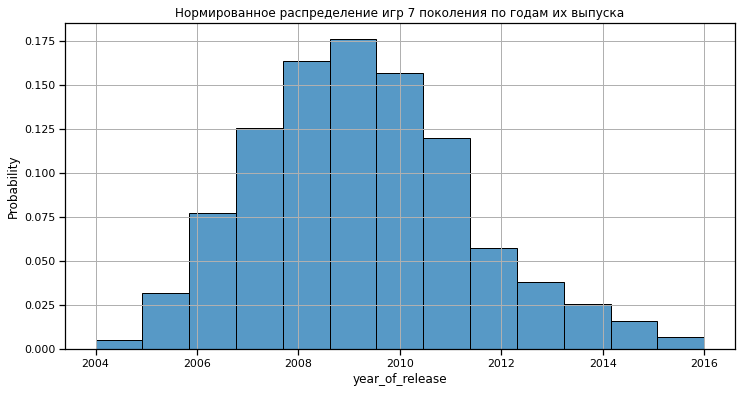

In [104]:
plt.figure(figsize=(12, 6))
sns.set_context("notebook")

sns.histplot(data=gen7model_df, x='year_of_release', bins=2016-2004+1, stat='probability') # 1 bin = 1 год

plt.title('Нормированное распределение игр 7 поколения по годам их выпуска')
plt.grid()
plt.show()

посмотрим когда и как начинаются у нас игры 8-ого поколения

In [105]:
gen8model_df = data_df.query('(generation == 8) & (year_of_release >= 2010)')

In [106]:
gen8model_df['year_of_release'].describe()

count    1736.000000
mean     2014.139401
std         1.545518
min      2011.000000
25%      2013.000000
50%      2014.000000
75%      2015.000000
max      2016.000000
Name: year_of_release, dtype: float64

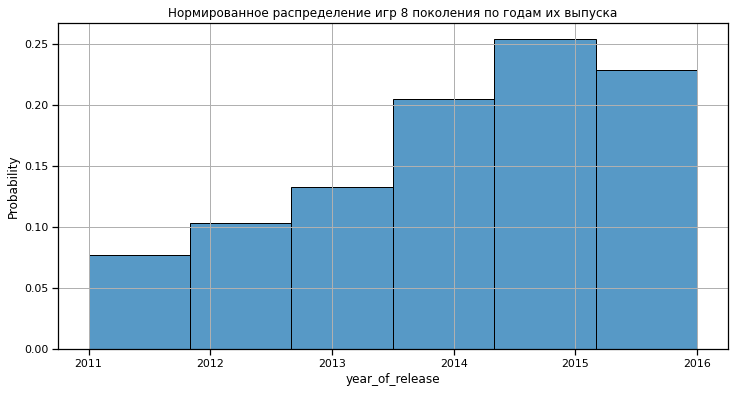

In [107]:
plt.figure(figsize=(12, 6))
sns.set_context("notebook")

sns.histplot(data=gen8model_df, x='year_of_release', bins=6, stat='probability') # 1 bin = 1 год

plt.title('Нормированное распределение игр 8 поколения по годам их выпуска')
plt.grid()
plt.show()

грубо аппроксимируя характер распределения 8-ого поколения 7-ым, мы можем считать 2016 год аналогом 2010. Соответственно 2011 будет аналогом искомого 2017.  Но проблема в том, что и продаж в 2010 году для 7-ого поколения мы не знаем - распределения продаж по годам выпуска игр - это совсем иное, чем продажи в какой-то год!  Нам придется строить упрощенную модель.  Возьмем в нулевом приближении, что каждая игра продается с постоянной скоростью кол-ва копий в год - с года своего появления в течении нескольких лет (например, 3-4 года).  

In [108]:
def yearly_sales_linefunc(df, year):
    game_sales_start = df['year_of_release']
    game_sales_period = 3 # 4 года, включая год начала и конца продаж - свободный параметр модели
    game_sales_stop = game_sales_start + game_sales_period
    if game_sales_stop > 2016: game_sales_stop = 2016
        
    game_copies_sold = df['total_sales']
    
    if (game_sales_start <= year <= game_sales_stop): return (game_copies_sold / (1+game_sales_stop-game_sales_start))
    else: return 0.0


for y in range(2004,2017):
    gen7model_df[str(y)] = gen7model_df.apply(yearly_sales_linefunc, axis=1, args=(y,))

C:\Users\aseva\AppData\Local\Temp\ipykernel_37500\281584115.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen7model_df[str(y)] = gen7model_df.apply(yearly_sales_linefunc, axis=1, args=(y,))


In [109]:
gen7model_df[['year_of_release','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016']]

,year_of_release,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,2006,0.0,0.0,20.6350,20.6350,20.6350,20.6350,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.00
2,2008,0.0,0.0,0.0000,0.0000,8.8800,8.8800,8.8800,8.8800,0.0000,0.0,0.0,0.0,0.00
3,2009,0.0,0.0,0.0000,0.0000,0.0000,8.1925,8.1925,8.1925,8.1925,0.0,0.0,0.0,0.00
6,2006,0.0,0.0,7.4500,7.4500,7.4500,7.4500,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.00
7,2006,0.0,0.0,7.2275,7.2275,7.2275,7.2275,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16673,2009,0.0,0.0,0.0000,0.0000,0.0000,0.0025,0.0025,0.0025,0.0025,0.0,0.0,0.0,0.00
16674,2007,0.0,0.0,0.0000,0.0025,0.0025,0.0025,0.0025,0.0000,0.0000,0.0,0.0,0.0,0.00
16677,2008,0.0,0.0,0.0000,0.0000,0.0025,0.0025,0.0025,0.0025,0.0000,0.0,0.0,0.0,0.00
16683,2016,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.01


In [110]:
year_list_7 = [str(x) for x in range(2004,2017)]
gen7model_df[year_list_7].sum().sum()

3918.73

Нормировка правильная - действительно общие продажи в 4-ом поколении были 3.9 миллиарда копий! Посмотрим распределение продаж по годам в 7-ом поколдении (то, что отсутствовало у нас до сих пор!):

In [111]:
sales_data = gen7model_df[year_list_7].sum()

sales_data_df = pd.DataFrame({
    'год продаж': np.array(sales_data.index),
    'годовые продажи копий': np.array(sales_data)
})


In [112]:
sales_data_df['год продаж'] = sales_data_df['год продаж'].astype('int')

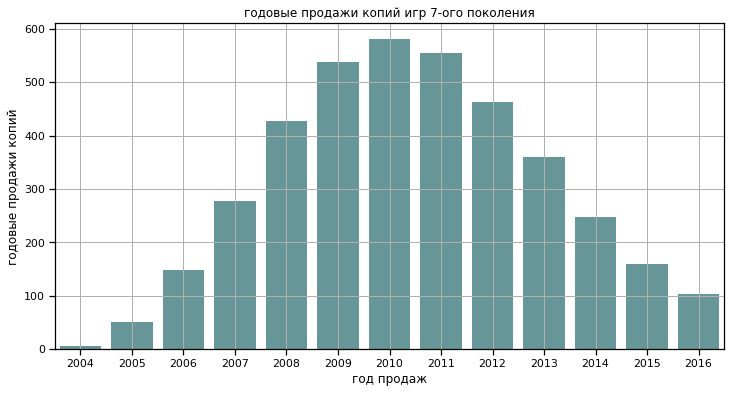

In [113]:
plt.figure(figsize=(12, 6))
sns.set_context("notebook")

sns.barplot(data=sales_data_df, 
            x='год продаж', y='годовые продажи копий', color='cadetblue')

plt.title('годовые продажи копий игр 7-ого поколения')
plt.grid()
plt.show()



Соответственно на 2010 год (аналог текущего момента 2016 по 8-ому поколению) в 7-ом поколении было продано: 

In [114]:
sales_data_df[sales_data_df['год продаж'] <= 2010]['годовые продажи копий'].sum()

2032.3250000000003

In [115]:
gen8model_df['total_sales'].sum()

868.72

По каким-то причинам, продажи 8-ого поколения идут гораздо хуже, чем это было в 7-ом.  Нормирующий коэффициент применения экстраполяции продаж в 7-ого поколения на продажи 8-ого равен 

In [116]:
sales_coeff_7to8 = gen8model_df['total_sales'].sum(
) / sales_data_df[sales_data_df['год продаж'] <= 2010]['годовые продажи копий'].sum()

print(sales_coeff_7to8)

0.42745131807166664


Соответственно, если никаких мер не будет предпринято, то **продажи 8-ого поколения в 2017 году составят** только:

In [117]:
sales_2017_8gen = sales_data['2011'] * sales_coeff_7to8

print('В 2017 году прогноз продаж игр для 8-ого поколения магазином', sales_2017_8gen, 'миллионов копий')

В 2017 году прогноз продаж игр для 8-ого поколения магазином 236.85184397180564 миллионов копий


**плюс в 2017 году будут допродаваться хвосты 7-ого поколения** - в нашей грубой модели это игры выпуска >= 2014 года:

In [118]:
sales_2017_7gen = gen7model_df.query('year_of_release >= 2014')['2016'].sum()

print('В 2017 году прогноз остаточных продаж игр для 7-ого поколения магазином', sales_2017_7gen, 'миллионов копий')

В 2017 году прогноз остаточных продаж игр для 7-ого поколения магазином 49.150000000000006 миллионов копий


**Остались игры для PC** - они выпали из расчетов выше, так как не имеют поколения платформы.  Посчитаем их просто также как допродажу 7-ого поколения, только по выборке с платформой PC:

In [119]:
onlyPCmodel_df = data_df.query('platform == "PC"')

In [120]:
onlyPCmodel_df['year_of_release'].describe()

count     974.000000
mean     2008.946612
std         4.632343
min      1985.000000
25%      2007.000000
50%      2010.000000
75%      2012.000000
max      2016.000000
Name: year_of_release, dtype: float64

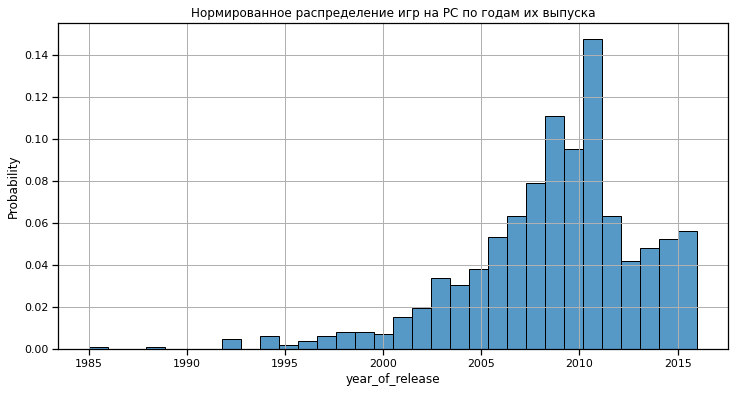

In [121]:
plt.figure(figsize=(12, 6))
sns.set_context("notebook")

sns.histplot(data=onlyPCmodel_df, x='year_of_release', bins=2016-1985+1, stat='probability') # 1 bin = 1 год

plt.title('Нормированное распределение игр на PC по годам их выпуска')
plt.grid()
plt.show()

In [122]:
for y in range(1985,2017): # функция заполнения та же, что была определена для построения модели продаж 7ого поколения
    onlyPCmodel_df[str(y)] = onlyPCmodel_df.apply(yearly_sales_linefunc, axis=1, args=(y,))

C:\Users\aseva\AppData\Local\Temp\ipykernel_37500\2858701687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onlyPCmodel_df[str(y)] = onlyPCmodel_df.apply(yearly_sales_linefunc, axis=1, args=(y,))


In [123]:
year_list_PC = [str(x) for x in range(1985,2017)]

sales_data_PC = onlyPCmodel_df[year_list_PC].sum()

sales_data_PC_df = pd.DataFrame({
    'год продаж': np.array(sales_data_PC.index),
    'годовые продажи копий': np.array(sales_data_PC)
})

sales_data_PC_df['год продаж'] = sales_data_PC_df['год продаж'].astype('int')

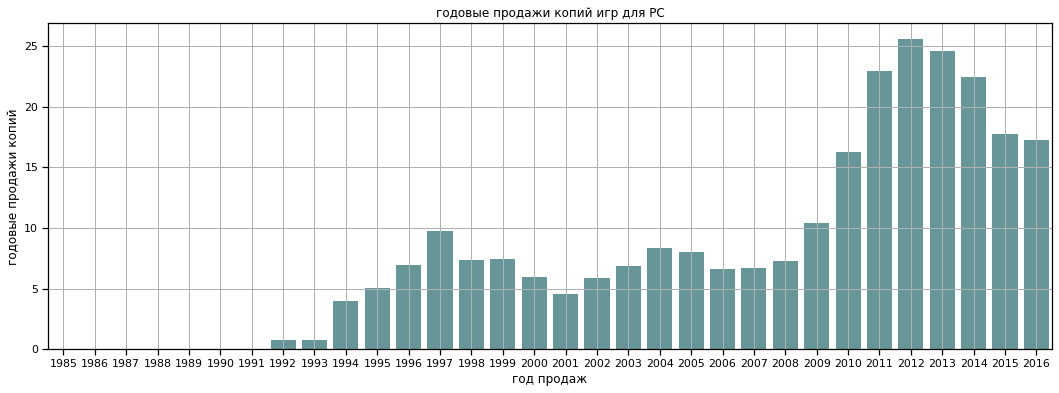

In [124]:
plt.figure(figsize=(18, 6))
sns.set_context("notebook")

sns.barplot(data=sales_data_PC_df, 
            x='год продаж', y='годовые продажи копий', color='cadetblue')

plt.title('годовые продажи копий игр для PC')
plt.grid()
plt.show()

отчетливо видны провалы продаж игр для PC при росте продаж игр для 6-7-8 поколений приставок, ну а появление существенных объемов игр для PC видно в 1992 году - с появлением первой комфортной PC платформы IBM PC AT 16MHz 1MB RAM и 20 MB HDD !

In [125]:
sales_2017_PC = onlyPCmodel_df.query('year_of_release >= 2014')['2016'].sum()

print('В 2017 году прогноз продаж игр для PC магазином', sales_2017_PC, 'миллионов копий')

В 2017 году прогноз продаж игр для PC магазином 13.981666666666667 миллионов копий


### Выводы из исследования:
1. Прогноз полных продаж копий игр на 2017 год составил 300 миллионов копий, 
 * из них 49 миллионов копий составят остатки продаж под платформы 7-ого поколения и
 * 237 миллионов копий обеспечат продажей платформы 8-ого поколения
 * 14 миллионов копий будет продано для PC
2. В целом, темпы роста продаж 8-ого поколения составляют на 2016 порядка 43% от темпов роста продаж 7-ого поколения в свое время на 2010 год.  Причинами снижения покупательской активности (через данный магазин), возможно, являются:
 * начало заката консольных игр - переход пользователей на сетевые многопользовательские платформы с простым клиентом
 * развитие веб-продаж - напрямую у разработчика или через немногих крупных аггрегаторов игрового контента и управления цифровыми правами пользователя (Steam, Origin и другие)
 * моральное устаревание продажи контента на DVD дисках и других материальных носителях, и несвоевременная перестройка магазина на другие формы
 * рост популярности модостроительства - как правило, ориентируется на платформу PC.

## Исследование: box-статистика трех лидеров производства игровых консолей 8 поколения

В прошлых исследованиях мы насмотрелись детальных графиков платформ 5-6-7 поколений и для трех вендоров-лидеров, но для ответа на вопросы исследований нам не нужно было рассматривать 8-ое поколение - так как оно только начиналось.  Возьмее опять тройку Sony, Nintendo и Microsoft - заметим что их продажи в 7-ом поколении были близки:

In [126]:
platforms_7and8_df = data_df.query('generation in [7,8]').groupby('platform', as_index=False)['total_sales'].agg(
    ['count','sum']).sort_values(by='sum',ascending=False).merge(
    platforms_df[['platform','vendor','portable','generation','platform_year']], how='left', on='platform')
# посмотрим на лидеров продаж и добавим другие характеристики платформ - чтобы сравнивать подобное с подобным

In [127]:
platforms_7and8_df

,platform,count,sum,vendor,portable,generation,platform_year
0,X360,1262,971.42,Microsoft,False,7.0,2005.0
1,PS3,1330,939.65,Sony,False,7.0,2006.0
2,Wii,1320,907.51,Nintendo,False,7.0,2006.0
3,DS,2151,806.12,Nintendo,True,7.0,2006.0
4,PS4,392,314.14,Sony,False,8.0,2013.0
5,PSP,1209,294.05,Sony,True,7.0,2005.0
6,3DS,520,259.00,Nintendo,True,8.0,2011.0
7,XOne,247,159.32,Microsoft,False,8.0,2013.0
8,WiiU,147,82.19,Nintendo,False,8.0,2012.0
9,PSV,430,54.07,Sony,True,8.0,2011.0


Итак, в 8-ом поколении у нас соревноваться будут: (PS4, WiiU, XOne) в категории приставок и (3DS, PSV) в категории портативных гаджетов.  Заметим, что в отличие от приставок 7-ого поколения пока что соревнование в приставках c двукратным отрывом выигрывает Sony, а в категории портативных приставок, несмотря на различие в ассортименте только на 20%, лидером с пятикратным отрывом является Nintendo

In [128]:
box_research_df = data_df.query('(generation == 8) & (total_sales <= 1.5)')

In [129]:
box_research_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596 entries, 1273 to 16687
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1596 non-null   object 
 1   platform         1596 non-null   object 
 2   year_of_release  1596 non-null   int32  
 3   genre            1596 non-null   object 
 4   na_sales         1596 non-null   float64
 5   eu_sales         1596 non-null   float64
 6   jp_sales         1596 non-null   float64
 7   other_sales      1596 non-null   float64
 8   critic_score     724 non-null    float64
 9   user_score       775 non-null    float64
 10  rating           890 non-null    object 
 11  total_sales      1596 non-null   float64
 12  vendor           1596 non-null   object 
 13  portable         1596 non-null   bool   
 14  platform_year    1596 non-null   float64
 15  generation       1596 non-null   float64
 16  score            790 non-null    float64
dtypes: bool(1)

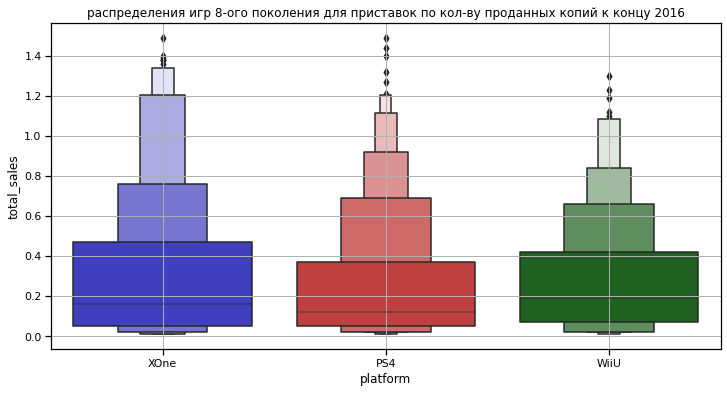

In [130]:
plt.figure(figsize=(12, 6))
sns.set_context("notebook")

sns.boxenplot(data=box_research_df.query('~portable'), 
            x='platform', y='total_sales', palette=['blue','red','green'], saturation=0.5)

plt.title('распределения игр 8-ого поколения для приставок по кол-ву проданных копий к концу 2016')
plt.grid()
plt.show()



In [131]:
box_research_df.query('~portable').groupby(by='platform')['total_sales'].describe().sort_values(by='std',ascending=False).merge(
    platforms_7and8_df[['platform','sum']], how='left', on='platform' 
)

,platform,count,mean,std,min,25%,50%,75%,max,sum
0,XOne,217.0,0.326313,0.379018,0.01,0.05,0.16,0.47,1.49,159.32
1,PS4,329.0,0.269362,0.317742,0.01,0.05,0.12,0.37,1.49,314.14
2,WiiU,135.0,0.294222,0.302792,0.01,0.07,0.19,0.42,1.30,82.19


Интересно, что максимальные продажи у платформы (PS4), у которой количество продаж на одну игру самое низкое - что по mean, что по median.  То есть, Sony лидируют в категории приставок за счет большого ассортимента игр - за счет хорошей партнерской работы с производителями игр!

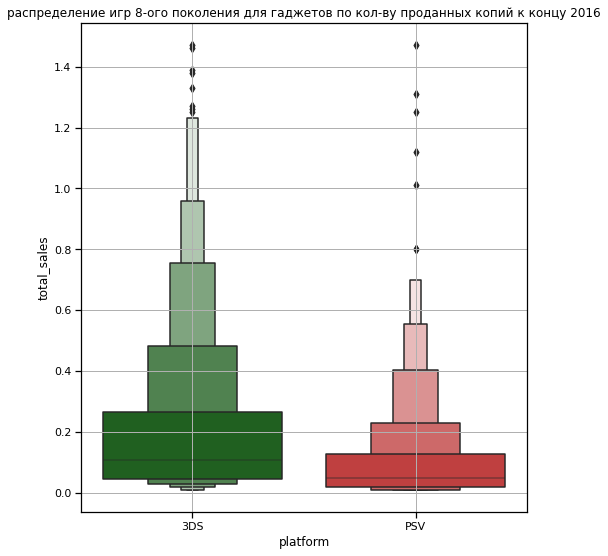

In [132]:
plt.figure(figsize=(8, 9))
sns.set_context("notebook")

sns.boxenplot(data=box_research_df.query('portable'), 
            x='platform', y='total_sales', palette=['green','red'], saturation=0.5)

plt.title('распределение игр 8-ого поколения для гаджетов по кол-ву проданных копий к концу 2016')
plt.grid()
plt.show()

In [133]:
paradox_df = box_research_df.query('portable').groupby(by='platform')['total_sales'].describe().merge(
    platforms_7and8_df[['platform','sum']], how='left', on='platform' 
)
paradox_df

,platform,count,mean,std,min,25%,50%,75%,max,sum
0,3DS,487.0,0.219035,0.276348,0.01,0.045,0.11,0.265,1.47,259.00
1,PSV,428.0,0.118154,0.180598,0.01,0.020,0.05,0.130,1.47,54.07


А здесь еще интереснее - Нинтендо лидирует в пять раз по продажам на 2016, при этом продаваемость игры в среднем в два раза выше, чем у Sony, а ассортимент различается процентов на 15-20.  Почему? - Для рационального объяснения остается только обрезанный при построении box-статистик хвост:

In [134]:
paradox_df['sales_in_tales'] = paradox_df['sum'] - ( paradox_df['count'] * paradox_df['mean'] )

In [135]:
paradox_df

,platform,count,mean,std,min,25%,50%,75%,max,sum,sales_in_tales
0,3DS,487.0,0.219035,0.276348,0.01,0.045,0.11,0.265,1.47,259.00,152.33
1,PSV,428.0,0.118154,0.180598,0.01,0.020,0.05,0.130,1.47,54.07,3.50


Очень интересно: у Nintendo в (520-487)=33 (6,3%) играх находится 152.33/259=58,8% продаж всех копий.

То есть, Nintendo пятикратно обгоняет по продажам Sony в категории портативных гаджетов за счет двух факторов: 
* во-первых, в основном распределении кол-во продаж одной игры вдвое больше - предполагается, что также благодаря стратегии Nintendo по быстрой атаке на рынок нового поколения платформ,
* во-вторых, большой процент игр Nintendo является хитом продаж - в основном распределении "сидит" процентов 40 от всех и продаж (тогда как у Sony более 90%) - предполагается, что это результат интенсивного и целевого маркетинга

### Вывод из исследования:

Box-статистика позволяет ожидать следующие факторы GtM трех лидеров продаж, как причину успехов и/или сдерживающий фактор их продаж:
1. Nintendo делает ставку на интенсивную маркетинг подготовку своей целевой группы к появлению новой платформы и игр к ней, в разультате косвенно видна повышенная лояльность пользователей бренду, быстрый выход и быстрая раскупаемость игр - аномально большая часть которых становится хитом уже к 2016 году!  Можно предположить, что ориентируется преимущественно на особенный рынок - очевидный вариант: японский.
2. Sony, по-видимому, в силу исторических причин ориентируется на открытый рынок, не забывая про японский, поэтому делает ставку на техническое качество (вклад смежного бизнеса компании) и большой ассортимент (работа с глобальными партнерами-производителями игр).  В результате является глобальным лидером продаж игр для приставок.
3. Microsoft вынужден балансировать между PC и приставками, избегая каннибализации одного своего бизнеса другим, поэтому уступает Sony в приставках и совсем не участвует в портативных гаджетах.  Возможно, планы в отношении платформы Nokia N-Gage, появлявшейся в 6-ом поколении портативных игровых консолей и приобретенной вместе с самой компанией (без Nokia NET), так и не имели успех - в последующих поколениях мы не видим ее убедительного продолжения, в частности в данном датафрейме.

## Исследование влияния отзывов критиков и пользователей на продажи

Исследование проведем на примере безусловного лидера и по ассортименту и по объемам продаж - платформе PS2

In [136]:
research_PS2_df = data_df.query('platform == "PS2"')

In [137]:
research_PS2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 17 to 16682
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2161 non-null   object 
 1   platform         2161 non-null   object 
 2   year_of_release  2161 non-null   int32  
 3   genre            2161 non-null   object 
 4   na_sales         2161 non-null   float64
 5   eu_sales         2161 non-null   float64
 6   jp_sales         2161 non-null   float64
 7   other_sales      2161 non-null   float64
 8   critic_score     1322 non-null   float64
 9   user_score       1268 non-null   float64
 10  rating           1496 non-null   object 
 11  total_sales      2161 non-null   float64
 12  vendor           2161 non-null   object 
 13  portable         2161 non-null   bool   
 14  platform_year    2161 non-null   float64
 15  generation       2161 non-null   float64
 16  score            1394 non-null   float64
dtypes: bool(1), 

In [138]:
research_PS2_df[['critic_score','user_score','total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.563193,0.394803
user_score,0.563193,1.000000,0.172308
total_sales,0.394803,0.172308,1.000000


Интересный результат: пользовательский рейтинг слабо коррелирует с продажами, а вот критики довольно неплохо предсказывают успех игры на рынке !  Посмотрим на это визуально:

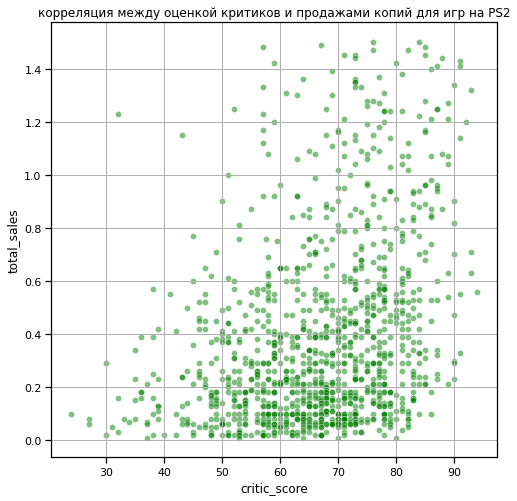

In [139]:
plt.figure(figsize=(8,8))
sns.set_context("notebook")

sns.scatterplot(data=research_PS2_df.query('total_sales <= 1.5' ), 
            x='critic_score', y='total_sales', color='green', alpha=0.5)

plt.title('корреляция между оценкой критиков и продажами копий для игр на PS2')
plt.grid()
plt.show()

М-м, интересно, что можно при сильном желании увидет здесь прямые лучи, исходящие из нуля под разными углами.  Похоже, что корреляция имеет следующий характер: для каждого узкого диапазона отзывов, например между 60 и 70 распределение игр по продажам экспоненциальное, причем коэффициент затухания экспоненты монотонно зависит от отзыва - чем хуже, тем быстрее затухает, то есть меньше продаж.  Посмотрим на примере трех диапазонов 50-60, 60_70 и 70-80:

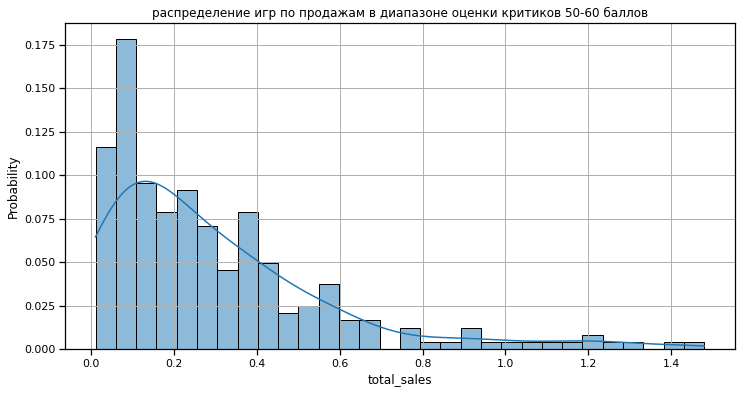

In [140]:
plt.figure(figsize=(12,6))
sns.set_context("notebook")

sns.histplot(data=research_PS2_df.query('(total_sales <= 1.5) & (critic_score >= 50) & (critic_score <= 60)' ), 
            x='total_sales', stat='probability', bins=15*2, kde=True)

plt.title('распределение игр по продажам в диапазоне оценки критиков 50-60 баллов')
plt.grid()
plt.show()

"период уполовинивания" такой экспоненты порядка 180 000 копий

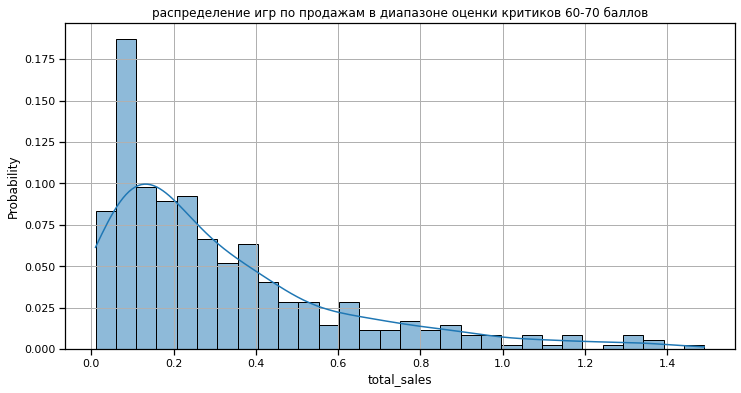

In [141]:
plt.figure(figsize=(12,6))
sns.set_context("notebook")

sns.histplot(data=research_PS2_df.query('(total_sales <= 1.5) & (critic_score >= 60) & (critic_score <= 70)' ), 
            x='total_sales', stat='probability', bins=15*2, kde=True)

plt.title('распределение игр по продажам в диапазоне оценки критиков 60-70 баллов')
plt.grid()
plt.show()

"период уполовинивания" такой экспоненты уже порядка 200 000 копий

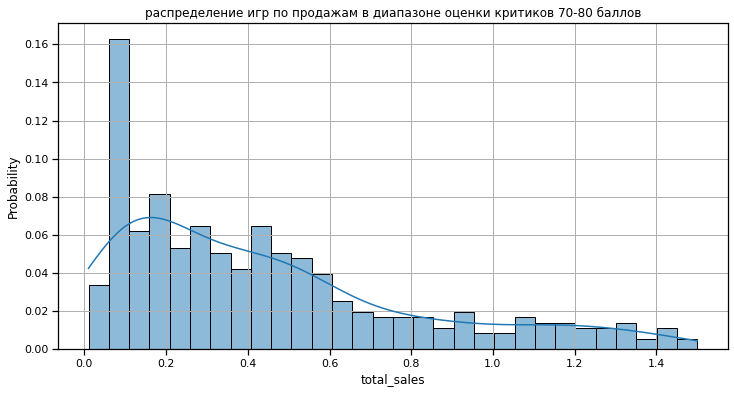

In [142]:
plt.figure(figsize=(12,6))
sns.set_context("notebook")

sns.histplot(data=research_PS2_df.query('(total_sales <= 1.5) & (critic_score >= 70) & (critic_score <= 80)' ), 
            x='total_sales', stat='probability', bins=15*2, kde=True)

plt.title('распределение игр по продажам в диапазоне оценки критиков 70-80 баллов')
plt.grid()
plt.show()

Ну тут уже даже kde не похожа на кривую $x^n e ^{-\alpha x}$, так что "период уполовинивания" не определить, но общий тренд виден - чем выше оценка, тем большая часть распределения перемещается в вытянутый хвост.

Визуальная корреляция с оценками пользователей ожидается еще хуже:

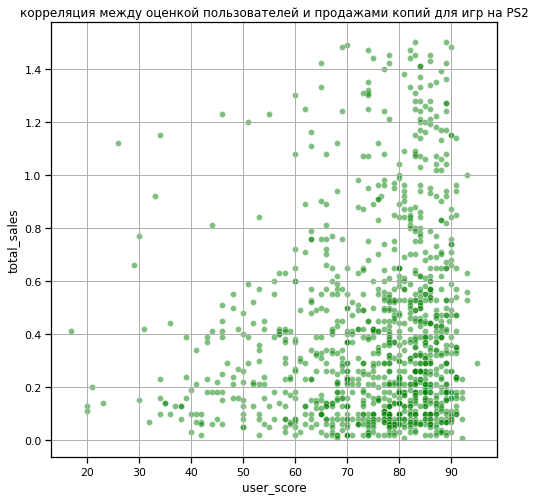

In [143]:
plt.figure(figsize=(8,8))
sns.set_context("notebook")

sns.scatterplot(data=research_PS2_df.query('total_sales <= 1.5' ), 
            x='user_score', y='total_sales', color='green', alpha=0.5)

plt.title('корреляция между оценкой пользователей и продажами копий для игр на PS2')
plt.grid()
plt.show()

принцип тот же, но пользователи более склонны оценивать понравившиеся игры и оценивают их выше.  Посмотрим для сравнения гистограмму в диапазоне 70-80:

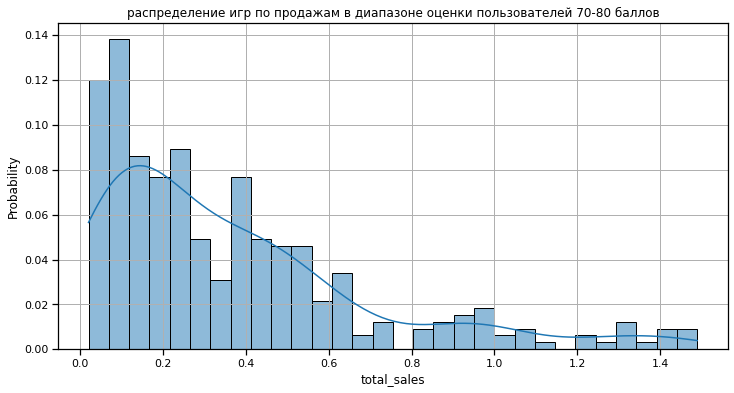

In [144]:
plt.figure(figsize=(12,6))
sns.set_context("notebook")

sns.histplot(data=research_PS2_df.query('(total_sales <= 1.5) & (user_score >= 70) & (user_score <= 80)' ), 
            x='total_sales', stat='probability', bins=15*2, kde=True)

plt.title('распределение игр по продажам в диапазоне оценки пользователей 70-80 баллов')
plt.grid()
plt.show()

Распределение сильнее поджато к малым цифрам продаж - что совпадает с ранее замеценной особенностью пользоваталей завышать оценку по сравнению с критиками - это распределение ожидается, что больше соответствует диапазону 65-75 для критиков.

**Посмотрим на корреляцию между продажами и оценками критиков и пользователей для других платформ:**

In [145]:
print('Платформа'.center(10),'|','Корр. с критиками'.center(20),'|','Корр. с пользователями'.center(20))
print('-'*(50+2*3))


for vd in ['Sony','Nintendo','Microsoft','Sega']:
    print('-'*20,'Вендор',vd,'-'*20)
    critic_count = 0
    user_count = 0
    critic_sum = 0.0
    user_sum = 0.0
    for pl in list( data_df.query('vendor == @vd')['platform'].value_counts().index ):
        one_pl_df = data_df.query('platform == @pl')
    
        critic_incr = one_pl_df['total_sales'].corr(one_pl_df['critic_score'])
        if (critic_incr >= 0.0) or (critic_incr <= 0.0): # корректная обработка NaN
            critic_sum += critic_incr
            critic_count += 1
        
        user_incr = one_pl_df['total_sales'].corr(one_pl_df['user_score'])
        if (user_incr >= 0.0) or (user_incr <= 0.0): # корректная обработка NaN
            user_sum += user_incr
            user_count += 1
           
        print(pl.center(10),'|', 
              str(round(one_pl_df['total_sales'].corr(one_pl_df['critic_score']),2)).center(20),'|', 
              str(round(one_pl_df['total_sales'].corr(one_pl_df['user_score']),2)).center(20))

    print('-'*(50+2*3))
    print('В среднем:'.center(10),'|', 
          str(round(critic_sum/critic_count,2)).center(20),'|', 
          str(round(user_sum/user_count,2)).center(20))
    print('-'*(50+2*3))

Платформа  |  Корр. с критиками   | Корр. с пользователями
--------------------------------------------------------
-------------------- Вендор Sony --------------------
   PS2     |         0.39         |         0.17        
   PS3     |         0.43         |         0.13        
   PSP     |         0.31         |         0.22        
    PS     |         0.45         |         0.3         
   PSV     |         0.13         |         0.0         
   PS4     |         0.4          |        -0.03        
--------------------------------------------------------
В среднем: |         0.35         |         0.13        
--------------------------------------------------------
-------------------- Вендор Nintendo --------------------
    DS     |         0.24         |         0.13        
   Wii     |         0.17         |         0.12        
   GBA     |         0.24         |         0.1         
    GC     |         0.33         |         0.23        
   3DS     |         0.35      

Та-Дамм!!! Patatras! Вот он, волнующий момент долгожданного открытия истины, когда сыщик из отдела аналитики данных предъявляет следствию безжалостные цифры доказательств - обратим внимание на то, как в среднем критики и пользователи оценивают разные платформы одного вендора:

### Выводы из исследования:

* **Microsoft** - уверенное понимание продуктовым маркетингом мейнстрима критики - самая высокая корреляция продаж и оценок среди лидеров (39%).  Но увы, простой пользователь живет совсем в другом мире - самая низкая (на уровне позорной) корреляция среди лидеров (7%). (Где-то я это уже слышал про Microsoft !)
* **Nintendo** - все наоборот: среди лидеров идут против мейнстрима - самая низкая корреляция продуктового маркетинга, хотя и тоже неплохая, с официальным мейнстримом (29%), зато самая высокая - с простыми пользователями (22%).  Выше мы уже делали предположение о фокусе GtM Nintendo на целевой работе маркетинга со своим сообществом пользователей, и как следствие, о максимальной лояльности последних бренду.  Это лишь еще одно подтверждение! 
* **Sony** - держится посередине, уверенно снимая сливки и там, и там: 35% корреляции с критиками и 13% корреляции с пользователями.
* **Sega** - аутсайдер гонки, сошедший с дистанции, и теперь понятно почему: все делали, вроде, правильно (25% корреляции с критиками), но получилось даже хуже, чем "как всегда" (**минус** 53% корреляции с пользователями).  Видимо, игроки Sega чувствовали себя как ежики из анекдота, которые кололись и плакали, но все равно лезли на кактус! 

Невозможно отдельно не отметить печальную историю Sega Saturn - не надо некритично слушать мейнстрим!  Sega добилась продвижения продаж именно тех игр, которые хвалили критики, но это оказалось полностью не соответствующим мнению игроков - в результате общие продажи оказались малы, а затраты маркетинга сфокусированы на бесперспективных целях!  И Sega покинула бизнес консолей после следующей попытки с DC, с которой уже были предприняты неверные решения продуктового маркетинга (уже и оценка критиков отрицательная).  Так что если кто-то ищет вопрос на то, что же произошло с консольным бизнесом Sega, то ответ скрыт в цифрах выше!

Данные корреляции также показывают, что в 8-ом поколении Microsoft (XOne) и Sony (PS4) имеют все шансы пережить похожую ситуацию, как было у Sega: они оба входят в 8-ое поколение с 40% совпедением продуктового маркетинга с мнением критической аналитики рынка, но корреляция с мнением пользователей у обоих отрицательная!   Сегодня (в 2016 году) на пике 8-ого поколения они имеют несогласие игроков со своими нововведениями!  При этом у Nintendo (WiiU) полное понимание с рынком - 39%.  Значит, Nintendo ожидает рост доли рынка за счет плохо понимающих рынок конкурентов (если только это не чисто региональный эффект - только в Японии.  Мы вернемся к этому вопросу в главе о региональном портрете пользователя).

## Исследование трендов продаж разных жанров

Жанр, является категорией, поэтому тут коррелятором взаимосвязь не померить!  Посмотрим как по поколениям игр меняется доля рынка между жанрами (по продажам)

In [146]:
research_genre_df = data_df.groupby(['generation','genre'],as_index=False)['total_sales'].agg('sum')

research_genre_df['generation_sales'] = research_genre_df.groupby('generation')['total_sales'].transform('sum')

research_genre_df['genre_share_per_generation'] = research_genre_df['total_sales'] / research_genre_df['generation_sales']

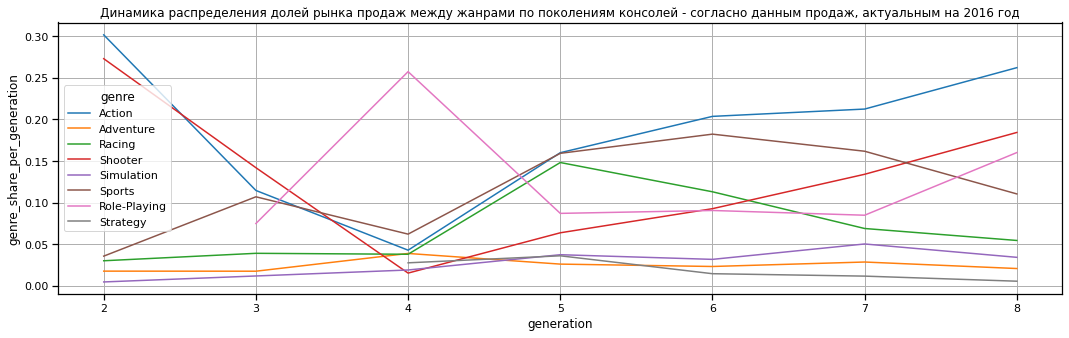

In [147]:
plt.figure(figsize=(18, 5))
sns.set_context("notebook")

sns.lineplot(data=research_genre_df.query(
    'genre in ["Action","Sports","Role-Playing","Shooter","Adventure","Racing","Simulation","Strategy"]'), 
             x='generation', y='genre_share_per_generation', hue='genre')

plt.title('Динамика распределения долей рынка продаж между жанрами по поколениям консолей - согласно данным продаж, актуальным на 2016 год')
plt.grid()
plt.show()

Интересный ренессанс старых хитов - жанры Action, Shooter и Role-Playing вновь на подъеме - в основном за счет падения смежных жанров Sports, Racing, Simulation.  Старые добрые темы Adventure, Strategy также потихоньку падают, но держат свою нишу фанатов

Отдадим должное начальству - построим пирог:

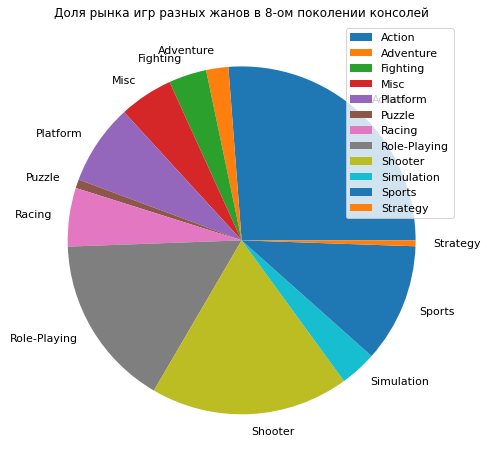

In [148]:
research_genre_df.query('generation == 8').set_index('genre').plot.pie(
    y='genre_share_per_generation', figsize=(15,8), ylabel=' ')

plt.title('Доля рынка игр разных жанов в 8-ом поколении консолей')
plt.show()

И таблица с цифрами в качестве вишенки к этому пирогу:

In [149]:
research_genre_df.query('generation == 8').sort_values(by='genre_share_per_generation', ascending=False)

,generation,genre,total_sales,generation_sales,genre_share_per_generation
68,8.0,Action,227.74,868.72,0.262156
76,8.0,Shooter,160.07,868.72,0.184260
75,8.0,Role-Playing,139.07,868.72,0.160086
78,8.0,Sports,95.87,868.72,0.110358
72,8.0,Platform,65.24,868.72,0.075099
74,8.0,Racing,47.27,868.72,0.054413
71,8.0,Misc,43.50,868.72,0.050074
70,8.0,Fighting,30.55,868.72,0.035167
77,8.0,Simulation,29.65,868.72,0.034131
69,8.0,Adventure,17.95,868.72,0.020663


Добавим к этой таблице относительную динамику между 7-ым и 8-ым поколениями:

In [150]:
research_genre_7to8_df = research_genre_df.query('generation == 8').merge(research_genre_df.query('generation == 7'
    )[['genre','genre_share_per_generation']], how='left', on='genre', suffixes=('_8','_7'))

research_genre_7to8_df['change_since_gen7'] = \
research_genre_7to8_df['genre_share_per_generation_8'] - research_genre_7to8_df['genre_share_per_generation_7']

research_genre_7to8_df.drop(columns='genre_share_per_generation_7', inplace=True)

In [151]:
research_genre_7to8_df.sort_values(by='genre_share_per_generation_8', ascending=False)

,generation,genre,total_sales,generation_sales,genre_share_per_generation_8,change_since_gen7
0,8.0,Action,227.74,868.72,0.262156,0.049764
8,8.0,Shooter,160.07,868.72,0.184260,0.050283
7,8.0,Role-Playing,139.07,868.72,0.160086,0.075324
10,8.0,Sports,95.87,868.72,0.110358,-0.051326
4,8.0,Platform,65.24,868.72,0.075099,0.018216
6,8.0,Racing,47.27,868.72,0.054413,-0.014384
3,8.0,Misc,43.50,868.72,0.050074,-0.078580
2,8.0,Fighting,30.55,868.72,0.035167,-0.000743
9,8.0,Simulation,29.65,868.72,0.034131,-0.016061
1,8.0,Adventure,17.95,868.72,0.020663,-0.007826


Все готово к выводам:
### Выводы из исследования:

За исключением малопредставленного жанра "Platform", относительный рост доли рынка демонстрируют безусловные лидеры рынка, забравшие вместе более 60% рынка 8-ого поколения и имеющие высокие темпы роста доли рынка - суммарно прибавили более 16% доли рынка только за одно поколение: это Action, Shooter и Role-Playing.  Все остальные жанры пока демонстрируют потерю рынка.  Сравнивать в абсолютных цифрах пока рано - налицо падение темпов продаж 8-ого поколения по сравнению с 7-ым для всех жанров.  Согласно нашей модели продаж среднее падение по всем жанрам порядка 43% на текущий этап цикла продаж поколения (см. детали в исследовании прогноза продаж на 2017 год выше), на которое для каждого конкретного жанра накладывается вышеописанный передел доли рынка внутри поколения.

# Региональные предпочтения пользователей

Различия по регионам задается только тeм, какой из столбцов продаж мы рассматриваем как основу для анализа предпочтений.  Речь идет о ситуации сегодня, поэтому чтобы избежать замешивания старых историй успеха 90-х годов, ограничимся только поколениями 7-8. 

## Регион Япония (jp)

### Самые популярные платформы

In [152]:
data_df.query('generation in [7,8]').groupby('platform',as_index=False)['jp_sales'].agg('sum').sort_values(
    by='jp_sales', ascending=False).merge(platforms_df, how='left',on='platform').drop(
    columns=['copies_sold_per_gen','copies_ratio_per_gen'])

,platform,jp_sales,platform_type,vendor,device,portable,platform_year,generation,games_sold,copies_sold
0,DS,175.57,NDS,Nintendo,Gadget,True,2006.0,7.0,2151,806.12
1,3DS,100.67,NDS,Nintendo,Gadget,True,2011.0,8.0,520,259.00
2,PS3,80.19,PlayStation,Sony,Console,False,2006.0,7.0,1330,939.65
3,PSP,76.78,PlayStation-P,Sony,Gadget,True,2005.0,7.0,1209,294.05
4,Wii,69.33,GameCube,Nintendo,Console,False,2006.0,7.0,1320,907.51
5,PSV,21.91,PlayStation-P,Sony,Gadget,True,2011.0,8.0,430,54.07
6,PS4,15.96,PlayStation,Sony,Console,False,2013.0,8.0,392,314.14
7,WiiU,13.01,GameCube,Nintendo,Console,False,2012.0,8.0,147,82.19
8,X360,12.43,Xbox,Microsoft,Console,False,2005.0,7.0,1262,971.42
9,XOne,0.34,Xbox,Microsoft,Console,False,2013.0,8.0,247,159.32


### Самые популярные жанры

In [153]:
data_df.query('generation in [7,8]').groupby('genre',as_index=False)['jp_sales'].agg('sum').sort_values(
    by='jp_sales', ascending=False)

,genre,jp_sales
7,Role-Playing,164.75
0,Action,98.77
3,Misc,70.45
10,Sports,43.24
4,Platform,37.38
9,Simulation,31.16
2,Fighting,26.70
1,Adventure,25.40
5,Puzzle,20.24
8,Shooter,18.29


### Статистика продаж по категориям контента ESRB

In [154]:
data_df.query('generation in [7,8]').groupby('rating',as_index=False)['jp_sales'].agg('sum').sort_values(
    by='jp_sales', ascending=False)

,rating,jp_sales
0,E,142.88
3,T,79.74
2,M,44.85
1,E10+,37.33


### Портрет игрока из Японии:
* Про существование такого производителя консолей как Микрософт либо не знает совсем, либо слабо слышал что-то от знакомых, которых, видимо, просто языковой барьер вынуждает пользоваться X-боксами (семьи экспатов и сотрудников посольств),
* В мобильных консолях предпочитает Nintendo и сразу скупает их новинки (3DS в топе уже и уступает только прошлому Nintendo DS!)
* Приставками интересуется существенно меньше, чем портативными гаджетами, а те, кто интересуется имеют более западный mindset - предпочитают Sony,
* помешаны на своих аниме - любимые жанры с огромным отрывом Role-Playing и Actions, также популярен Sport.  Из огнестрельного оружия людей убивать не любят (Shooter), и завоевывать мир - тоже (Strategy),
* из восьмого поколения первой пробивает дорогу на рынок портативная платформа,
* взрослые люди меньше играют в игры чем тинейджеры.

## Регион Европа ЕС (eu)

### Самые популярные платформы

In [155]:
data_df.query('generation in [7,8]').groupby('platform',as_index=False)['eu_sales'].agg('sum').sort_values(
    by='eu_sales', ascending=False).merge(platforms_df, how='left',on='platform').drop(
    columns=['copies_sold_per_gen','copies_ratio_per_gen'])

,platform,eu_sales,platform_type,vendor,device,portable,platform_year,generation,games_sold,copies_sold
0,PS3,330.29,PlayStation,Sony,Console,False,2006.0,7.0,1330,939.65
1,X360,270.76,Xbox,Microsoft,Console,False,2005.0,7.0,1262,971.42
2,Wii,262.21,GameCube,Nintendo,Console,False,2006.0,7.0,1320,907.51
3,DS,188.89,NDS,Nintendo,Gadget,True,2006.0,7.0,2151,806.12
4,PS4,141.09,PlayStation,Sony,Console,False,2013.0,8.0,392,314.14
5,PSP,66.68,PlayStation-P,Sony,Gadget,True,2005.0,7.0,1209,294.05
6,3DS,61.48,NDS,Nintendo,Gadget,True,2011.0,8.0,520,259.00
7,XOne,51.59,Xbox,Microsoft,Console,False,2013.0,8.0,247,159.32
8,WiiU,25.13,GameCube,Nintendo,Console,False,2012.0,8.0,147,82.19
9,PSV,13.12,PlayStation-P,Sony,Gadget,True,2011.0,8.0,430,54.07


### Самые популярные жанры

In [156]:
data_df.query('generation in [7,8]').groupby('genre',as_index=False)['eu_sales'].agg('sum').sort_values(
    by='eu_sales', ascending=False)

,genre,eu_sales
0,Action,333.42
10,Sports,235.47
8,Shooter,220.27
3,Misc,148.61
6,Racing,119.28
7,Role-Playing,91.70
4,Platform,84.23
9,Simulation,61.89
2,Fighting,40.14
1,Adventure,33.12


### Статистика продаж по категориям контента ESRB

In [157]:
data_df.query('generation in [7,8]').groupby('rating',as_index=False)['eu_sales'].agg('sum').sort_values(
    by='eu_sales', ascending=False)

,rating,eu_sales
0,E,472.81
2,M,372.28
3,T,202.51
1,E10+,168.28


### Портрет игрока из Европы:
* В одинаковой степени пользуется всеми тремя лидерами рынка приставок, отдавая небольшое (но в пределах допустимой толерантности) предпочтение техническому совершенству Sony,
* В мобильных консолях предпочитает Nintendo - явное превосходство над Sony, но как стиль жизни и игры предпочитает приставки,
* Люди действия (Action) и постоянного соревнования (Sports, Racing), не против доказать свое превосходство в естественном отборе и более радикальными методами - если издалека и не пачкая руки (Shooter).  А вот драке (Fighting) предпочитают ее симуляцию (Simulation).  Романтической фигней не заморачиваются (Role-Playing и Adventure), но хорошо усвоили, что завоевывать мир - это нехорошо (Strategy)
* восьмое поколение не так торопится на рынок, как в Японии, первой пробивает дорогу на рынок приставка Sony,
* взрослые люди вовсю шпилят в игры, в то время как тинейджеры заняты чем-то еще (проводят дни ЛГБТ-толерантности в школе, наверное).

## Регион США и Канада (na)

### Самые популярные платформы

In [158]:
data_df.query('generation in [7,8]').groupby('platform',as_index=False)['na_sales'].agg('sum').sort_values(
    by='na_sales', ascending=False).merge(platforms_df, how='left',on='platform').drop(
    columns=['copies_sold_per_gen','copies_ratio_per_gen'])

,platform,na_sales,platform_type,vendor,device,portable,platform_year,generation,games_sold,copies_sold
0,X360,602.47,Xbox,Microsoft,Console,False,2005.0,7.0,1262,971.42
1,Wii,496.90,GameCube,Nintendo,Console,False,2006.0,7.0,1320,907.51
2,PS3,393.49,PlayStation,Sony,Console,False,2006.0,7.0,1330,939.65
3,DS,382.40,NDS,Nintendo,Gadget,True,2006.0,7.0,2151,806.12
4,PSP,109.17,PlayStation-P,Sony,Gadget,True,2005.0,7.0,1209,294.05
5,PS4,108.74,PlayStation,Sony,Console,False,2013.0,8.0,392,314.14
6,XOne,93.12,Xbox,Microsoft,Console,False,2013.0,8.0,247,159.32
7,3DS,83.49,NDS,Nintendo,Gadget,True,2011.0,8.0,520,259.00
8,WiiU,38.10,GameCube,Nintendo,Console,False,2012.0,8.0,147,82.19
9,PSV,12.58,PlayStation-P,Sony,Gadget,True,2011.0,8.0,430,54.07


### Самые популярные жанры

In [159]:
data_df.query('generation in [7,8]').groupby('genre',as_index=False)['na_sales'].agg('sum').sort_values(
    by='na_sales', ascending=False)

,genre,na_sales
0,Action,507.49
10,Sports,373.35
8,Shooter,365.48
3,Misc,281.07
7,Role-Playing,180.31
6,Racing,141.03
4,Platform,138.50
9,Simulation,113.69
2,Fighting,86.50
1,Adventure,59.62


### Статистика продаж по категориям контента ESRB

In [160]:
data_df.query('generation in [7,8]').groupby('rating',as_index=False)['na_sales'].agg('sum').sort_values(
    by='na_sales', ascending=False)

,rating,na_sales
0,E,806.61
2,M,563.20
3,T,392.32
1,E10+,307.20


### Портрет игрока из США и Канады:
* В части субъективных предпочтений (жанра и контента) имеем практически идентичную картину, что и в Европе - с единственным различием, что два рядомстоящих в рейтинге популярности жанра Role-Playing и Racing идут, все же, в различном порядке.  Поэтому не будем второй раз приводить здель описание игрока из Европы - дадим только разницу,  
* А вот в предпочтениях платформ, за которые на смерть бьются мартетинги конкурентов, видим некоторое различие, по-видимому, проистекающее из позиции японских вендоров, особенно Nintendo: рынок США и Канады гораздо проще для маркетинга, чем Европейский: один язык (немного французского в Монреале и Квебеке ничего не меняет, так как там все на том же уровне знают и английский (в отличие от Франции, например)), усредненное культурное кодирование - продвижение в этом регионе явно понятнее продуктовому маркетингу Nintendo, чем в Европе.  Поэтому мы видим, как впереди широкими колоннами идут уже продвинутые платформы 7-ого поколения, за ними в ряд выстроились платформы 8-ого поколения,
* На первом месте с неплохим запасом - Microsoft (уф, ну хоть здесь-то!), то есть, это только среди приставок, но просто портативные гаджеты ему не интересны как бизнес, а то бы...,
* А вот среди выходящих на рынок платформ 8-ого поколения приставка Sony, все же, лидирует, хотя ей мало уступает XOne,
* Предпочтения игроманов явно в пользу приставок, хотя Nintendo очень старается - в 8-ом поколении видно, что они сфокусировали ресурсы маркетинга в первую очередь на сегменте портативных гаджетов, хотя в 7-ом они сумели пропихнуть свою приставку Wii даже выше PlayStation.

# Проверка гипотез

## Гипотеза о равенстве средних пользовательских рейтингов  платформ XOne и PC
Сразу отметим, что платформы для сравнения выбраны неудачно - в датафрейме игры для PC имеют спан с 1992 года по 2016, а игры под XOne - с года появления платформы 2013 по 2016.  Поэтому для корректного сравнения нам придется тоже выбрать только игры под PC с годом выпуска не ранее 2013.

* $H_0$ - средние значения двух статвеличин совпадают
* $H_1$ - альтернативная гипотеза: средние значения двух статвеличин различные

По вопросу о выборе интервала достоверности - поскольку речь идет о бытовом сравнении рейтингов, и не предполагается какая-то серия опытов по перепроверке, то интервал достоверности берем обычный 95%, альфа = 0.05  

In [161]:
selection_PC = data_df[data_df['user_score'].notna()].query('(platform == "PC")&(year_of_release >= 2013)')['user_score']
selection_PC.describe()

count    160.000000
mean      62.768750
std       17.419436
min       14.000000
25%       53.000000
50%       68.000000
75%       76.000000
max       93.000000
Name: user_score, dtype: float64

In [162]:
selection_XOne = data_df[data_df['user_score'].notna()].query('platform == "XOne"')['user_score']
selection_XOne.describe()

count    193.000000
mean      65.624352
std       13.813681
min       16.000000
25%       58.000000
50%       68.000000
75%       75.000000
max       92.000000
Name: user_score, dtype: float64

In [163]:
compare_result = st.ttest_ind(selection_XOne, selection_PC, equal_var=False)
compare_result

Ttest_indResult(statistic=1.681170669739733, pvalue=0.09376915120236422)

Как видим, статистический тест показывает, что рейтинги различаются менее чем на 1,96 суммарного стандартного отклонения (первый парамет compare_results), соответствующего интервалу доверия 95%, соответственно pvalue 0.094 > alpha 0.05.  Поэтому ответ:

### Вывод по проверке гипотезы:
Гипотеза о равенстве средних пользовательских рейтингов  платформ XOne и PC **не противоречит** данными настоящего датафрейма в диапазоне достоверности 95% (1.96 $\sigma$).

**Существенное замечание:** при проверки гипотезы выборка данных по рейтингам PC платформы была ограничена тем же временным диапазоном, что и у XOne: 2013-2016 годами.  На наш взгляд, это необходимо для корректного ответа на вопрос гипотезы, поскольку вкусы пользователей могут меняться со временем. 

Заметим про роль сужения выборки по PC: мы были довольно близки к опровержению гипотезы 1.68$\sigma$ вместо 1.96$\sigma$ - а вот если бы выборка PC была взята за все года, то $\sigma$ ee среднего была бы в $\sqrt{n}$ раз меньше $\sigma$ выборки по PC и при том же расстоянии между средними выборок, это расстояние оценивалось бы параметром compare_result.statistic в большее число сигм - соответственно pvalue было бы меньше!  Но и расстояние между средними могло бы просто оказаться меньше при большей выборке - если гипотеза права!

## Гипотеза о различии средних для пользовательских рейтингов жанров Action и Sports
Оба жанра присутствуют во всех поколениях игр, поэтому нам не нужно ограничивать временной интервал - чем больше будет записей в выборках, тем меньше их общее стандартное отклонение, тем достовернее различаться средние!

* $H_0$ - средние значения двух статвеличин совпадают
* $H_1$ - альтернативная гипотеза: средние значения двух статвеличин различные

По вопросу о выборе интервала достоверности - поскольку речь идет о бытовом сравнении рейтингов, и не предполагается какая-то серия опытов по перепроверке, то интервал достоверности берем обычный 95%, альфа = 0.05  

In [164]:
selection_Action = data_df[data_df['user_score'].notna()].query('genre == "Action"')['user_score']
selection_Action.describe()

count    1933.000000
mean       70.404294
std        14.242389
min         3.000000
25%        63.000000
50%        73.000000
75%        80.000000
max        95.000000
Name: user_score, dtype: float64

In [165]:
selection_Sports = data_df[data_df['user_score'].notna()].query('genre == "Sports"')['user_score']
selection_Sports.describe()

count    1205.000000
mean       69.516183
std        16.181101
min         2.000000
25%        61.000000
50%        74.000000
75%        81.000000
max        95.000000
Name: user_score, dtype: float64

In [166]:
compare_result = st.ttest_ind(selection_Action, selection_Sports, equal_var=False)
compare_result

Ttest_indResult(statistic=1.5645489952450853, pvalue=0.11782556548435719)

Увы, на этот раз для подтверждения исходной гипотезы нам нужно, чтобы pvalue на этот раз было меньше альфа.  Поэтому ответ на гипотезу негативный:

### Вывод по проверке гипотезы:
Гипотеза о неравенстве средних пользовательских рейтингов жанров Action и Sports **не может быть подтверждена** данными настоящего датафрейма с достоверностью 95%.

# Отчет о проведении проекта

## Проведена предобработка данных.

### Названия столбцов приведены к нижнему регистру:

Легко.

### Преобразованы типы данных:

1. Столбец year_of_release - после полного заполнения пропусков приведен к типу int.
2. Столбец user_score - после обработки значения "tbd" приведен к численному типу, также домножен на 10 для общей шкалы с critic_score - возможность количественного сравнения рейтингов критиков и пользователей.

### Удалены полностью записи датафрейма:

1. Две записи с отсутствующими данными об имени и жанре игры - удалены, так как это ключевые параметры анализа данных, без которых данные записи были бы бесполезны.
2. Один явный дупликат "Madden NFL 13 / PS3 / 2012.0 / Sports" - наиболее очевидная причина проанализирована как форк записей о продажах, поэтому данные продаж аггрегированы в одну запись.
3. 24 записи малопредставленных в статистике вендоров платформ: NEC (3 записи), Panasonic (3 записи), Bandai (6 записей) и Nokia (12 записей) - причины удаления многочисленны, включая но не ограничиваясь: ничтожное представленность в датафрейме, малые продажи копий, все кроме Нокии до 2000 года (а Нокию давно уже купил Микрософт).
4. От удаления малопредставленных значений категорий контента (столбец rating) отказались после изучения в Интернет семантики аббревиатур - оказалось возможным влить их в гораздо более полные группы (осталось 4 многочисленные группы: E, T, M и E10+)

Итого из начальных 16715 записей датафрейма удалены 27 (0.16%), оставшиеся 16688 записей после предобработки переданы на вход EDA.

### Заполнены пропуски в данных:

1. Полностью заполнен столбец year_of_release.  Применены последовательно несколько подходов:
 * 19 пробелов заполнено автоматическим анализом имен игр на предмет наличия в них 2000-2016 или 80-99, в качестве дополнительной проверки делалось сравнение с годом появления платформы на рынке
 * 98 пробелов заполнено модой года в группировке игр по имени, наиболее соответствующей году выхода платформы.
 * 136 пробелов заполнены годом выхода платформы плюс 3 года (наименее точное заполнение из всех в списке - ошибка +/- 3 года)
 * 16 пробелов на платформе PC (по причине отсутствия у нее года появления на рынке) заполнены вручную - поиском по имени игры в  Интернет
2. Частично заполнен столбец critic_score: было 8136 ненулевых записи, стало 8383 (+3.0%).
3. Частично заполнен столбец user_score: было 7589 ненулевых записи, стало 8016 (+5.6%).  Значение "tbd" было заменено на NaN, чтобы сделать возможным численный анализ статистики.  Кроме того, в конце этот столбец был перенормирован на общую шкалу со столбцом critic_score - для возможности сравнительного анализа и проверки гипотезы о совпадении мнений критиков и пользователей (опровергнута).
 * Оба столбца score заполнялись методом среднего по группировке по имя+поколение+портативность
 * Идея заполнять по группировке жанр+платформа была отклонена, так как это уж очень "среднее по больнице" и дало бы на распределениях вероятности половину записей в дельта функциях нескольких значений (популярных средних).  Такое заполнение никак не повлияло бы на точность выводов (в сторону их увеличения, по крайней мере), с другой стороны, для анализа качественных трендов достаточно и половины записей датафрейма - если отсутствие носит случайный характер.
 * для дополнительного улучшения заполнения на 10% был добавлен столбец score со средним рейтингом от критиков и пользователей - в нем 8922 записи (где был только один рейтинг вместо среднего бралось единственное ненулевое значение)
4. Частично заполнен столбец rating: было 9948 ненулевых записи, стало 10239 (+2.9%).  Был применен единственный автоматический метод - замена на среднее по группировке имя+портативность.  Дальнейших возможностей заполнения нет - контент слабо зависит от жанра, за исключением специфических жанров (но у нас была только одна запись с таким контентом на весь датасет - GTA, конечно!), поэтому принято решение также использовать частичную статистику для анализа трендов, как и в случае столбцов score. 

### Добавлены дополнительные столбцы для удобства анализа

1. Поскольку ассортимент игр не достаточен для анализа существенности факторов продаж, в датафрейм был сразу же добавлен столбец суммарных продаж по регионам:
 * total_sales.
2. По результатам анадиза столбца platform было проведено небольшое интернет исследования и аббревиатуры платформ дополнены следующими столбцами с деталями о платформах:
 * vendor - производитель платформ.  После удаления несущественных осталось только пять, из них три актуальных сегодня - Sony, Microsoft и Nintendo.
 * portable - каждый производитель производит два класса консолей для игр: приставки к ТВ и карманные гаджеты.  Статистика по ним сильно различается - при анализе нами даже был выявлен гартнеровский хайп-цикл для карманных гаджетов, поэтому в зависимости от поколений, предпочтения рынка сильно различаются.  Для PC используется значение False.
 * platform_year - год появления платформы на рынке.  Параметр сильно помог для заполнения года выпуска игры - для разделения мод года в группе.
 * generation - поколение платформ.  Временная динамика трендов хорошо видна именно в развертке по поколениям.  Даже удалось следать оценку годового роста продаж копий игр на основе этой динамики.


### Во время предобработки были сделаны предварительные выводы:

1. Доля мобильных платформ среди проданных копий игр в разных поколениях четко демонстрирует хайп-цикл новой технологии Гартнера:
 * в четвертом поколении она появляется из нуля и сразу взлетает до 53% рынка
 * в пятом поколении полное разочарование и падение доли портативных платформ до нуля
 * начиная с шестого поколения она демонстрирует стабильный рост: 16% в 6-ом, 28% в 7-ом и 37% в 8-ом поколениях
2. С третьего по седьмое поколения включительно объемы продаж (копий игр) демонстрируют довольно точное удвоение каждое новое поколение.
3. У 87% ассортимента игр продано менее миллиона копий на игру, и только у 1% игр продано более 5 миллионов копий на игру (принцип 80 на 20 в данном проекте)
4. Рейтинги критики и пользователей (после приведения к общей шкале) совершенно точно (23 девятки) не совпадают: мнения критиков более умеренные и имеют более широкий диапазон, тогда как у пользователей доминируют эмоции от пережитого опыта игры, и они склонны более категорично выделять свои субъективные предпочтения - распределение уже и пик смещен к большим значениям
5. Причиной отсутствия большой части рейтингов является то, что для игр с малой статистикой продаж их просто не трудились собирать.
6. В исходных данных присутствует крайне неудачная точность округления объемов продаж до 10000 копий - в результате по регионам примерно у половины игр продажи округлены до нуля! 

## Проведен исследовательский анализ данных (EDA).
В том числе:

### Исследование вопроса об ассортименте игр по годам их выпуска со следующим Заключением:
Проанализированная динамика выпуска ассортимента по годам демонстрирует сильную корреляцию (с коэффициентом 0.924) с годами выхода платформ, под которые они писались. Поэтому в распределении игр по годам выпуска присутствуют моды, соответствующие разным поколениям платформ. Данные моды делают неравномерными многие распределения параметров по годам выпуска игр - присутствуют волнообразности с "длиной волны" в одно поколение. Из чего следует наша рекоментация рассматривать временную динамику не по годам выпуска игр, а по поколениям платформ.

### Исследование объемов продаж игр для тройки платформ-лидеров по годам их производства со следующим Заключением:
1. Продажи игр под одну платформу определенного поколения продолжается порядка 10-11 лет (+/- год идет за счет подгонки производителями дат выхода - к концу года или к началу).  
2. Пики продаж достигаются для ассортимента игр производства в середине этого периода - практически за один-два года до появления следующего поколения той же платформы 
3. Таким образом, распределение продаж имеет пирамидальную форму, 
 * причем левый склон пирамиды имеет явную выпуклость вверх - что отражает как желание продьюсеров увеличить срок активных продаж сдвигом года выпуска игры к началу срока платформы, так и, собственно, результирующий более продолжительный срок продаж игр на левом склоне, по сравнению с правым
 * а правый склон пирамиды имеет менее явную, но, все же, заметную вогнутость вниз - что отражает как нежелание продьюсеров инвестировать в игры, ориентированные на платформы, уже заканчивающие свою службу и сменяемые в данное время следующим поколением платформ, как и реально более короткий срок из продаж - тсключение здесь составляют "хиты", которые вытягивают хвост вправо и сподвигают продьюсеров раскошеливаться на меньшую прибыль, но при меньших же рисках.

### Исследование вопроса о прогнозе продаж на 2017 год со следующим Заключением:
1. Построена прогностическая модель продаж в 2017 году для трех компонент продаж:
 * экстраполяционная модель продаж с 7-ого поколения на 8-ое - предсказывает продажи игр 8-ого поколения в 2017 году,
 * экстенсивная модель допродаж игр 7-ого поколения в 2017 году,
 * экстенсивная модель продаж игр для PC в 2017 году.
2. Для перехода от распределения продаж по годам выпуска игр к распределению продаж по годам продаж была неоходима некоторая модель продаж, информация о которой полностью отсутствовала в датафрейме - там была лишь привязка к году выпуска игры.  Поэтому нам пришлось предложить упрощенную модель продажи игры, основываясь на следующих предположениях:
 * игра продается после года выпуска в течение 4 лет включительно с одинаковой скоростью (обеспечивая к 2016 году суммарную цифру продаж, доступную в датафрейме),
 * временные циклы продаж и игр 7-ого и - нового на год прогноза - 8-ого поколений приблизительно гомотетичны с точностью до нормировки на полные цифры продаж к 2016 году, доступные в датафрейме,
 * в рамках такой гомотетии можно экстраполировать 2010 год на кривой 7-ого поколения на 2016 год на кривой 8-ого поколения, потом провести нормирование на цифры продаж и определить коэффициент экстраполяции продаж 2011 года по 7-ому поколению на прогноз продаж 2017 года по 8-ому поколению. 
3. Прогноз полных продаж копий игр на 2017 год составил 300 миллионов копий, 
 * из них 49 миллионов копий составят остатки продаж под платформы 7-ого поколения,
 * 237 миллионов копий обеспечат продажей платформы 8-ого поколения,
 * и 14 миллионов копий будет продано для PC.
4. В целом, темпы роста продаж 8-ого поколения составляют на 2016 порядка 43% от темпов роста продаж 7-ого поколения в свое время на 2010 год.  Причинами снижения покупательской активности (через данный магазин), возможно, являются:
 * начало заката консольных игр - переход пользователей на сетевые многопользовательские платформы с простым клиентом
 * развитие веб-продаж - напрямую у разработчика или через немногих крупных аггрегаторов игрового контента и управления цифровыми правами пользователя (Steam, Origin и другие)
 * моральное устаревание продажи контента на DVD дисках и других материальных носителях, и несвоевременная перестройка магазина на другие формы
 * рост популярности модостроительства - как правило, ориентируется на платформу PC.

### Исследование box-статистики трех лидеров производства игровых консолей 8 поколения со следующим Заключением:
Box-статистика позволяет ожидать следующие стратегии GtM трех лидеров продаж, как причину успехов и/или сдерживающий фактор их продаж:
1. Nintendo делает ставку на интенсивную маркетинг подготовку своей целевой группы к появлению новой платформы и игр к ней, в разультате косвенно видна повышенная лояльность пользователей бренду, быстрый выход и быстрая раскупаемость игр - аномально большая часть которых становится хитом уже к 2016 году!  Можно предположить, что ориентируется преимущественно на особенный рынок - очевидный вариант: японский.
2. Sony, по-видимому, в силу исторических причин ориентируется на открытый рынок, не забывая про японский, поэтому делает ставку на техническое качество (вклад смежного бизнеса компании) и большой ассортимент (работа с глобальными партнерами-производителями игр).  В результате является глобальным лидером продаж игр для приставок.
3. Microsoft вынужден балансировать между PC и приставками, избегая каннибализации одного своего бизнеса другим, поэтому уступает Sony в приставках и совсем не участвует в портативных гаджетах.  Возможно, планы в отношении платформы Nokia N-Gage, появлявшейся в 6-ом поколении портативных игровых консолей и приобретенной вместе с самой компанией (без Nokia NET), так и не имели успех - в последующих поколениях мы не видим ее убедительного продолжения, в частности в данном датафрейме.

### Исследование влияния отзывов критиков и пользователей на продажи со следующим Заключением:
Корреляция между продажами и отзывами от слабой к средней, лучше у критиков, чем у пользователей.  Самая сильная корреляция у предпоследней платформы Sega Saturn - как у критиков, так и у пользователей (на уровне 69% и там, и там), но самое удивительное, что при этом она разного знака, то есть Sega продвигала продажи игр, следуя мнению критиков, но совершенно не угадала, что нравится игрокам (и Sega этого, видимо, не пережила!).  Что послужило основой для заключительного положения выводов по данному исследованию ниже:
* **Microsoft** - уверенное понимание продуктовым маркетингом мейнстрима критики - самая высокая корреляция продаж и оценок среди лидеров (39%).  Но увы, простой пользователь живет совсем в другом мире - самая низкая (на уровне позорной) корреляция среди лидеров (7%). (Где-то я это уже слышал про Microsoft !)
* **Nintendo** - все наоборот: среди лидеров идут против мейнстрима - самая низкая корреляция продуктового маркетинга, хотя и тоже неплохая, с официальным мейнстримом (29%), зато самая высокая - с простыми пользователями (22%).  Выше мы уже делали предположение о фокусе GtM Nintendo на целевой работе маркетинга со своим сообществом пользователей, и как следствие, о максимальной лояльности последних бренду.  Это лишь еще одно подтверждение! 
* **Sony** - держится посередине, уверенно снимая сливки и там, и там: 35% корреляции с критиками и 13% корреляции с пользователями.
* **Sega** - аутсайдер гонки, сошедший с дистанции, и теперь понятно почему: все делали, вроде, правильно (25% корреляции с критиками), но получилось даже хуже, чем "как всегда" (**минус** 53% корреляции с пользователями).  Видимо, игроки Sega чувствовали себя как ежики из анекдота, которые кололись и плакали, но все равно лезли на кактус! 

Данные корреляции также показывают, что в 8-ом поколении Microsoft (XOne) и Sony (PS4) имеют все шансы пережить похожую ситуацию, как было у Sega: они оба входят в 8-ое поколение с 40% совпедением продуктового маркетинга с мнением критической аналитики рынка, но корреляция с мнением пользователей у обоих отрицательная!   Сегодня (в 2016 году) на пике 8-ого поколения они имеют несогласие игроков со своими нововведениями!  При этом у Nintendo (WiiU) полное понимание с рынком - 39%.  Значит, Nintendo ожидает рост доли рынка за счет плохо понимающих рынок конкурентов (если только это не чисто региональный эффект - только в Японии).

### Исследование трендов продаж разных жанров со следующим Заключением:
За исключением малопредставленного жанра "Platform", относительный рост доли рынка демонстрируют безусловные лидеры рынка, забравшие вместе более 60% рынка 8-ого поколения и имеющие высокие темпы роста доли рынка - суммарно прибавили более 16% доли рынка только за одно поколение: это Action, Shooter и Role-Playing.  Все остальные жанры пока демонстрируют потерю рынка.  Сравнивать в абсолютных цифрах поколения пока рано - налицо падение темпов продаж 8-ого поколения по сравнению с 7-ым для всех жанров.  Согласно нашей модели продаж среднее падение по всем жанрам порядка 43% на текущий этап цикла продаж поколения (см. детали в исследовании прогноза продаж на 2017 год выше), на которое для каждого конкретного жанра накладывается вышеописанный передел доли рынка внутри поколения.

## Составлен "портрет пользователя" каждого региона (NA, EU, JP) в разрезе предпочтений платформ, жанров и категории контента по рейтингу ESRB.

### Портрет игрока из Японии (JP):
* Про существование такого производителя консолей как Микрософт либо не знает совсем, либо слабо слышал что-то от знакомых, которых, видимо, просто языковой барьер вынуждает пользоваться X-боксами (семьи экспатов и сотрудников посольств),
* В мобильных консолях предпочитает Nintendo и сразу скупает их новинки (3DS в топе уже и уступает только прошлому Nintendo DS!)
* Приставками интересуется существенно меньше, чем портативными гаджетами, а те, кто интересуется имеют более западный mindset - предпочитают Sony,
* помешаны на своих аниме - любимые жанры с огромным отрывом Role-Playing и Actions, также популярен Sport.  Из огнестрельного оружия людей убивать не любят (Shooter), и завоевывать мир - тоже (Strategy),
* из восьмого поколения первой пробивает дорогу на рынок портативная платформа,
* взрослые люди меньше играют в игры чем тинейджеры.

### Портрет игрока из Европы (EU):
* В одинаковой степени пользуется всеми тремя лидерами рынка приставок, отдавая небольшое (но в пределах допустимой толерантности) предпочтение техническому совершенству Sony,
* В мобильных консолях предпочитает Nintendo - явное превосходство над Sony, но как стиль жизни и игры предпочитает приставки,
* Люди действия (Action) и постоянного соревнования (Sports, Racing), не против доказать свое превосходство в естественном отборе и более радикальными методами - если издалека и не пачкая руки (Shooter).  А вот драке (Fighting) предпочитают ее симуляцию (Simulation).  Романтической фигней не заморачиваются (Role-Playing и Adventure), но хорошо усвоили, что завоевывать мир - это нехорошо (Strategy)
* восьмое поколение не так торопится на рынок, как в Японии, первой пробивает дорогу на рынок приставка Sony,
* взрослые люди вовсю шпилят в игры, в то время как тинейджеры заняты чем-то еще (проводят дни ЛГБТ-толерантности в школе, наверное).

### Портрет игрока из США и Канады (NA):
* В части субъективных предпочтений (жанра и контента) имеем практически идентичную картину, что и в Европе - с единственным различием, что два рядомстоящих в рейтинге популярности жанра Role-Playing и Racing идут, все же, в различном порядке.  Поэтому не будем второй раз приводить здель описание игрока из Европы - дадим только разницу,  
* А вот в предпочтениях платформ, за которые на смерть бьются мартетинги конкурентов, видим некоторое различие, по-видимому, проистекающее из позиции японских вендоров, особенно Nintendo: рынок США и Канады гораздо проще для маркетинга, чем Европейский: один язык (немного французского в Монреале и Квебеке ничего не меняет, так как там все на том же уровне знают и английский (в отличие от Франции, например)), усредненное культурное кодирование - продвижение в этом регионе явно понятнее продуктовому маркетингу Nintendo, чем в Европе.  Поэтому мы видим, как впереди широкими колоннами идут уже продвинутые платформы 7-ого поколения, за ними в ряд выстроились платформы 8-ого поколения,
* На первом месте с неплохим запасом - Microsoft (уф, ну хоть здесь-то!), то есть, это только среди приставок, но просто портативные гаджеты ему не интересны как бизнес, а то бы...,
* А вот среди выходящих на рынок платформ 8-ого поколения приставка Sony, все же, лидирует, хотя ей мало уступает XOne,
* Предпочтения игроманов явно в пользу приставок, хотя Nintendo очень старается - в 8-ом поколении видно, что они сфокусировали ресурсы маркетинга в первую очередь на сегменте портативных гаджетов, хотя в 7-ом они сумели пропихнуть свою приставку Wii даже выше PlayStation.

## Проверены гипотезы.
### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые:
### Вывод по проверке гипотезы:
Гипотеза о равенстве средних пользовательских рейтингов  платформ XOne и PC **не противоречит** данным настоящего датафрейма в диапазоне достоверности 95% (1.96 $\sigma$).

**Существенное замечание:** при проверки гипотезы выборка данных по рейтингам PC платформы была ограничена тем же временным диапазоном, что и у XOne: 2013-2016 годами.  На наш взгляд, это необходимо для корректного ответа на вопрос гипотезы, поскольку вкусы пользователей могут меняться со временем. 

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
### Вывод по проверке гипотезы:
Гипотеза о неравенстве средних пользовательских рейтингов жанров Action и Sports **не может быть подтверждена** данными настоящего датафрейма с достоверностью 95%.


# Заключение по проекту

## Замечания об исходных данных

1. В исходных данных было бы полезно иметь информацию о производителе игры.  Успех продаж зависит от бренда.
2. Совершенно недопустимо совершенное поставщиком исходного файла данных округление объемов продаж игр до 10000 - из-за этого до половины игр на отдельных рынках не имеют продаж - округлены в ноль!  При такой степени разрешения ухудшается точность анализа предпочтений.
3. В целом, для корректного анализа годовых продаж копий игр исходных данных недостаточно - данные продаж датафрейма соответствуют только полным продажам игры за все время.  Желательно дополнить данный датасет хотя бы данными годовых продаж по каждой игре.  Иначе это приходится довольно грубо моделировать и экстраполировать.

## Методология прогноза продаж
1. Мы делим продажи в 2017 году на три группы:
 * продажи игр для PC,
 * допродажи игр уходящего 7-ого поколения консолей,
 * продажи игр нового 8-ого поколения консолей.
2. Для пересчета цифр продаж по годам производства игр в цифры ежегодных продаж каждой игры мы предложили упрощенную модель: игра продается с постоянным темпом в течение несколькох лет, набирая за эти годы цифру полных продаж.  Кол-во лет продажи игры - свободный параметр для подгонки нормировки к 2016 году.
3. В данной модели продаж вклад первых двух групп расчитывается просто - все игры с (2016 - минус срок продаж игры) дают вклад в продажи 2017 года, равный своим полным продажам, деленным на (год выхода игры минус 2016). (Везде, где надо по логике, идет +1 год в период.)
4. Продажи игр 8-ого поколения оцениваются экстраполяцией продаж игр 7-ого поколения по следующей логике: 
 * предполагается, что кривые цикла продаж будут схожи - только объемы будут различаться,
 * кривая 7-ого поколения рассчитывается с помощью модели продаж и по данным датафрейма для 7-ого поколения,
 * проводится соответствие между годами поколений, находящимися в "одной фазе цикла продаж поколения": 2010 в 7-ом соответствует 2016 в 8-ом,
 * определяется сколько было продано в 7-ом к 2010 году и сравнивается с цифрами продаж 8-ого из дата фрейма на 2016,  
 * это сравнение дает нормировочный коэффициент, на который домножаем продажи 7-ого поколения в 2011 году, и используем в качестве прогноза продаж 8-ого поколения в 2017 году.
 5. Складываем вместе все три вклада в продажи.

## Прогноз продаж на 2017 год
Прогноз полных продаж копий игр на 2017 год составил 300 миллионов копий,
* из них 49 миллионов копий составят остатки продаж под платформы 7-ого поколения,
* 237 миллионов копий обеспечат продажей платформы 8-ого поколения,
* и 14 миллионов копий будет продано для PC.

## Выводы и рекомендации магазину
1. В целом, темпы роста продаж 8-ого поколения Вашим магазином составляют на конец 2016 года порядка 43% от темпов роста продаж 7-ого поколения в свое время на конец 2010 года. 
2. Причинами снижения темпов осваивания продаж 8-ого поколения Вашим магазином, возможно, являются:
* начало заката консольных игр - переход пользователей на сетевые многопользовательские платформы с простым клиентом
* развитие веб-продаж - напрямую у разработчика или через немногих крупных аггрегаторов игрового контента и управления цифровыми правами пользователя (Steam, Origin и другие)
* моральное устаревание продажи контента на DVD дисках и других материальных носителях, и несвоевременная перестройка Вашего магазина на другие формы
* рост популярности модостроительства - как правило, ориентируется на платформу PC, мало продаваемую Вашим магазином.
3. При выборе приоритетных направлений исправления ситуации рекомендуем учитывать следующие прогнозы:
* жанры Action, Shooter и Role-Playing заняли 60% рынке игр и продолжат свой рост
* среди консолей 8-ого поколения наиболее успешной у игроков-покупателей будет Nintendo
* популярность портативных гаджетов будет расти

In [167]:
print('end of "Run All" execution')

end of "Run All" execution
